In [1]:
import cartopy
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib notebook

sys.path.append("../marinetraffic/")

from vesseltracks import read_vesseltracks_file

In [2]:
windfarms = pd.read_excel("../../data/windfarms/windfarms-complete_turbines.ods", engine="odf")
windfarms.set_index("index", inplace=True)
windfarms.turbine_installation_vessel = windfarms.turbine_installation_vessel.apply(lambda x : [i.lower().lstrip().replace(" ", "-") for i in str(x).split(",")])

In [3]:
def get_cluster_coord_year(basedir, min_locations=6):
    for vesseldir in glob.glob(os.path.join(basedir, "*")):
        vesselkey = os.path.basename(vesseldir)
        for clusterdir in glob.glob(os.path.join(vesseldir, "cluster_*")):
            clustername = os.path.basename(clusterdir)
            if (n_locations := len(glob.glob(os.path.join(clusterdir, "*location_*.csv")))) < 6:
                # print(f"only {n_locations} single locations available at {clusterdir}, skipping")
                continue
            if os.path.isfile(cluster_fpath := os.path.join(clusterdir, f"{vesselkey}_{clustername}.csv")):
                cluster = read_vesseltracks_file(cluster_fpath)
                lat_mean = cluster.latitude.mean()
                lon_mean = cluster.longitude.mean()
                yield (vesselkey, clustername, lat_mean, lon_mean)

In [21]:
def match_cluster_windfarm(clustered_vesseltracks_dir, windfarms, lower_bound=0.1, upper_bound=0.1, verbose=False):
    matchN = 1
    for (vesselkey, clustername, cluster_lat, cluster_lon) in get_cluster_coord_year(clustered_vesseltracks_dir):
        vesselname = vesselkey.split("_")[-1]
        for windfarm in windfarms.itertuples():
            lat_lower = windfarm.latitude - lower_bound
            lat_upper = windfarm.latitude + upper_bound
            lon_lower = windfarm.longitude - lower_bound
            lon_upper = windfarm.longitude + upper_bound
            if lat_lower < cluster_lat < lat_upper and lon_lower < cluster_lon < lon_upper and vesselname in windfarm.turbine_installation_vessel:
                if verbose:
                    print(f"found possible match {matchN}: {windfarm.Index} {windfarm.name}: {vesselkey}/{clustername}", end=" ")
                    print(f"vessel match: {vesselname} -> {windfarm.turbine_installation_vessel}", end=" ")                 
                    print("")
                matchN += 1
                yield (windfarm.Index, windfarm.name, vesselkey, clustername, cluster_lat, cluster_lon)

In [5]:
def plot_cluster(
    vessel_tracks: pd.DataFrame,
    windfarm,
    title : str = "",
    label : str = "",
    margin : float = 0.1,
    figsize : tuple =(9, 9),
    save_fig="",
    verbose=False,
    transparent=True,
    show_fig=False,
):
    figure = plt.figure(figsize=figsize)
    if transparent:
        figure.patch.set_alpha(0)
    min_lat = vessel_tracks.latitude.min() - margin
    max_lat = vessel_tracks.latitude.max() + margin
    min_lon = vessel_tracks.longitude.min() - margin
    max_lon = vessel_tracks.longitude.max() + margin
    if verbose:
        print(
            f"min_lat: {min_lat} min_lon: {min_lon} max_lat: {max_lat} max_lon: {max_lon}"
        )
    ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cartopy.feature.BORDERS)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.scatter(vessel_tracks['longitude'], vessel_tracks['latitude'], transform=cartopy.crs.PlateCarree(), label=label, color="gray", alpha=0.25, s=75)
    plt.scatter(windfarm.longitude, windfarm.latitude, color='tab:red', transform=cartopy.crs.PlateCarree(), label=windfarm["name"])
    plt.scatter(vessel_tracks.longitude.mean(), vessel_tracks.latitude.mean(), transform=cartopy.crs.PlateCarree(), label="vessel tracks centroid", color='tab:green')
    plt.legend()
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    if show_fig:
        plt.show()

In [22]:
matching_windfarms = pd.DataFrame(data=match_cluster_windfarm("../../data/marinetraffic/clustered/", windfarms, verbose=True), columns=["windfarm_index", "windfarm_name", "vesselname", "clustername", "cluster_lat", "cluster_lon"])
matching_windfarms.index.name = 'index'

found possible match 1: 66 Sandbank: 245924000_adventure/cluster_11 vessel match: adventure -> ['adventure'] 
found possible match 2: 41 Teesside: 245924000_adventure/cluster_1 vessel match: adventure -> ['adventure'] 
found possible match 3: 68 Rampion: 245924000_adventure/cluster_12 vessel match: adventure -> ['discovery', 'adventure'] 
found possible match 4: 57 Amrumbank West: 245924000_adventure/cluster_6 vessel match: adventure -> ['adventure'] 
found possible match 5: 41 Teesside: 245924000_adventure/cluster_3 vessel match: adventure -> ['adventure'] 
found possible match 6: 99 Moray East: 215644000_blue-tern/cluster_4 vessel match: blue-tern -> ['blue-tern', 'bold-tern'] 
found possible match 7: 71 Wikinger: 229044000_brave-tern/cluster_4 vessel match: brave-tern -> ['brave-tern'] 
found possible match 8: 47 Global Tech I: 229044000_brave-tern/cluster_2 vessel match: brave-tern -> ['thor', 'brave-tern', 'bold-tern', 'vole-au-vent', 'innovation'] 
found possible match 9: 76 Gall

In [23]:
matching_windfarms

windfarm_index         windfarm_name                vesselname  \
index                                                                   
0                  66              Sandbank       245924000_adventure   
1                  41              Teesside       245924000_adventure   
2                  68               Rampion       245924000_adventure   
3                  57        Amrumbank West       245924000_adventure   
4                  41              Teesside       245924000_adventure   
5                  99            Moray East       215644000_blue-tern   
6                  71              Wikinger      229044000_brave-tern   
7                  47         Global Tech I      229044000_brave-tern   
8                  76              Galloper       229080000_bold-tern   
9                  89    Borkum Riffgrund 2       229080000_bold-tern   
10                 99            Moray East       229080000_bold-tern   
11                 69             Veja Mate       229080000_bold-tern   
12                 47         Global Tech I       229080000_bold-tern   
13                 54    EnBW Baltic II (J)    218657000_vole-au-vent   
14                 56   EnBW Baltic II (MP)    218657000_vole-au-vent   
15                 73             Nobelwind    218657000_vole-au-vent   
16                101         Northwester 2    218657000_vole-au-vent   
17                 52             Northwind      246777000_resolution   
18                 36                 Lincs      246777000_resolution   
19                 17  Lynn & Inner Dowsing      246777000_resolution   
20                 55        Humber Gateway      246777000_resolution   
21                 97         Kriegers Flak    253366000_vole-au-vent   
22                 80            Tahkoluoto    253366000_vole-au-vent   
23                 73             Nobelwind    253366000_vole-au-vent   
24                101         Northwester 2    253366000_vole-au-vent   
25                 90         Borssele I/II  219019002_sea-challenger   
26                 93       East Anglia One  219019002_sea-challenger   
27                 96               Hornsea  219019002_sea-challenger   
28                 70               Dudgeon  219019002_sea-challenger   
29                 84                Arkona  219019002_sea-challenger   
30                 63      Gode Wind I & II  219019002_sea-challenger   
31                 59      Westermost Rough  219019002_sea-challenger   
32                 98                Merkur       235090598_blue-tern   
33                103      Trianel Borkum 2       235090598_blue-tern   
34                103      Trianel Borkum 2       235090598_blue-tern   
35                 87              Albatros       235090598_blue-tern   
36                 47         Global Tech I            218389000_thor   
37                 31        BARD Oﬀshore I            218389000_thor   
38                100               Norther          245179000_aeolus   
39                 65                Gemini          245179000_aeolus   
40                 61         Luchterduinen          245179000_aeolus   

      clustername  cluster_lat  cluster_lon  
index                                        
0      cluster_11    55.208181     6.847074  
1       cluster_1    54.585541    -1.192003  
2      cluster_12    50.666104    -0.261201  
3       cluster_6    54.518640     7.700167  
4       cluster_3    54.644194    -1.093048  
5       cluster_4    58.159199    -2.703396  
6       cluster_4    54.840417    14.047760  
7       cluster_2    54.449967     6.275349  
8       cluster_9    51.914191     2.067811  
9      cluster_11    53.951454     6.502348  
10      cluster_7    58.218493    -2.775849  
11      cluster_8    54.326712     5.873987  
12      cluster_3    54.510643     6.369832  
13      cluster_1    54.972794    13.156890  
14      cluster_1    54.972794    13.156890  
15      cluster_5    51.668886     2.811856  
16      cluster_5    51.668886     2.81

<IPython.core.display.Javascript object>


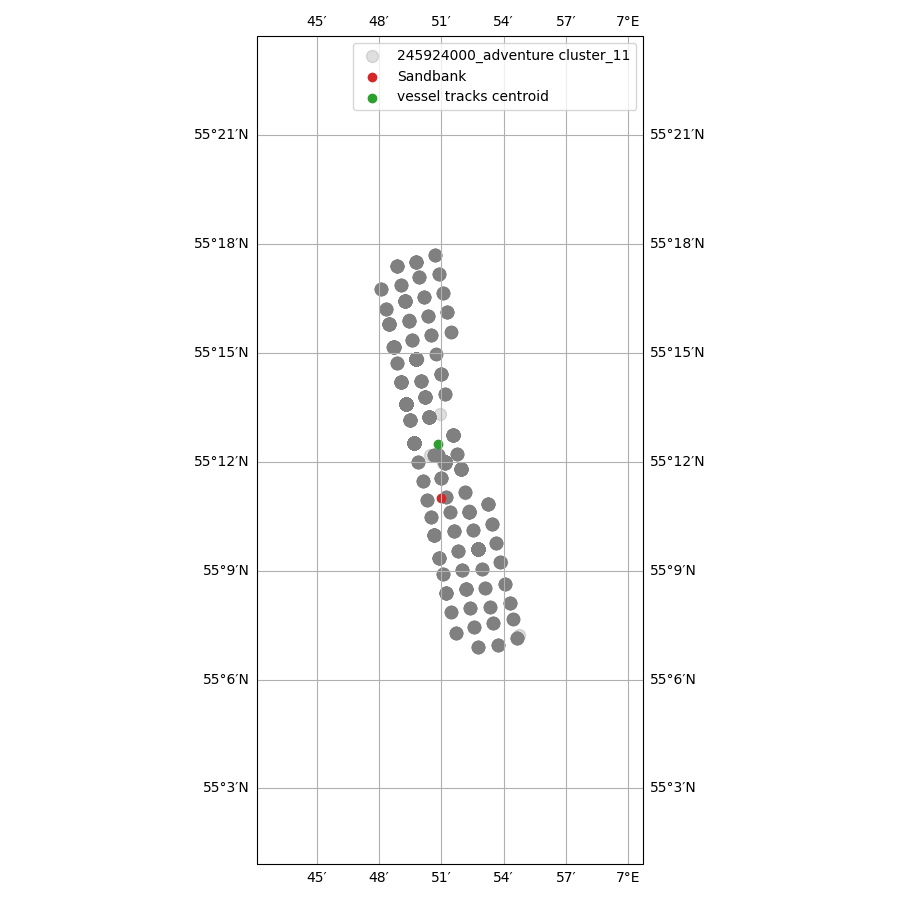

<IPython.core.display.Javascript object>


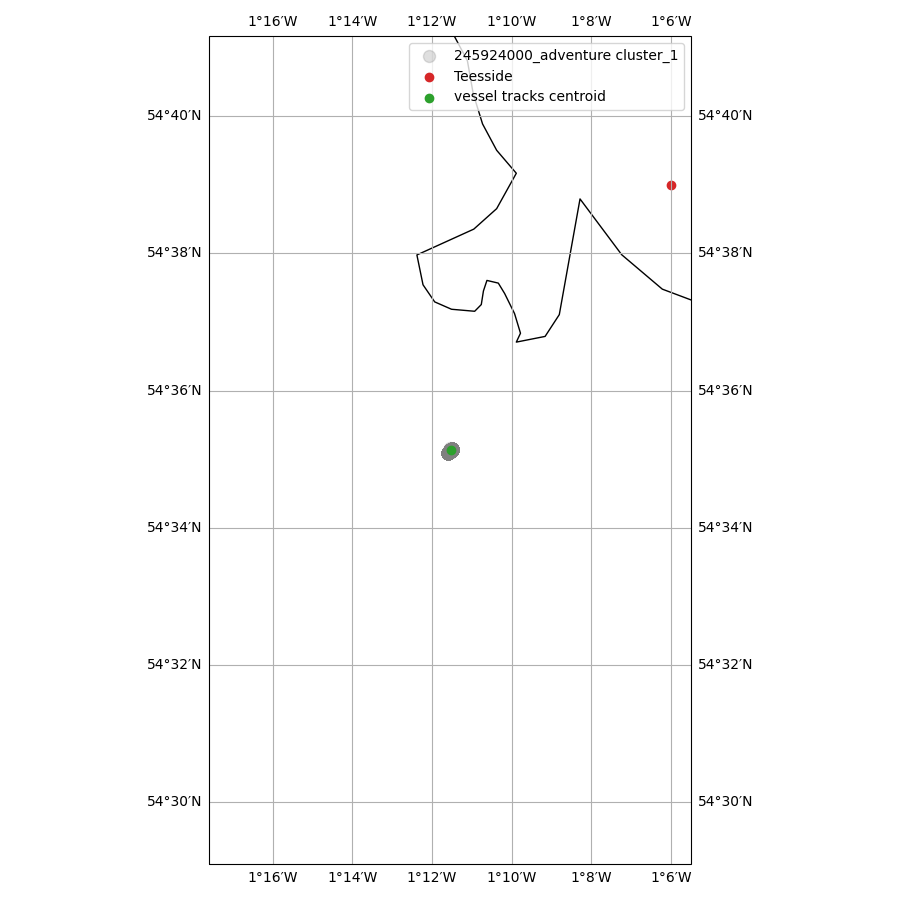

<IPython.core.display.Javascript object>


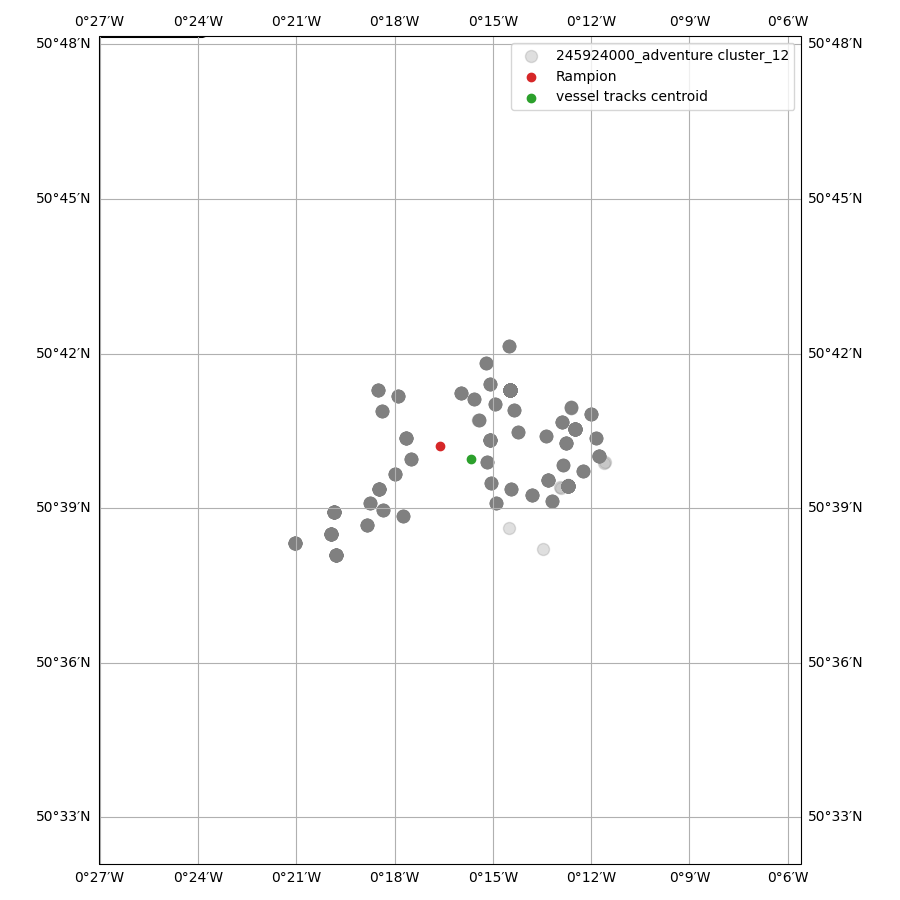

<IPython.core.display.Javascript object>


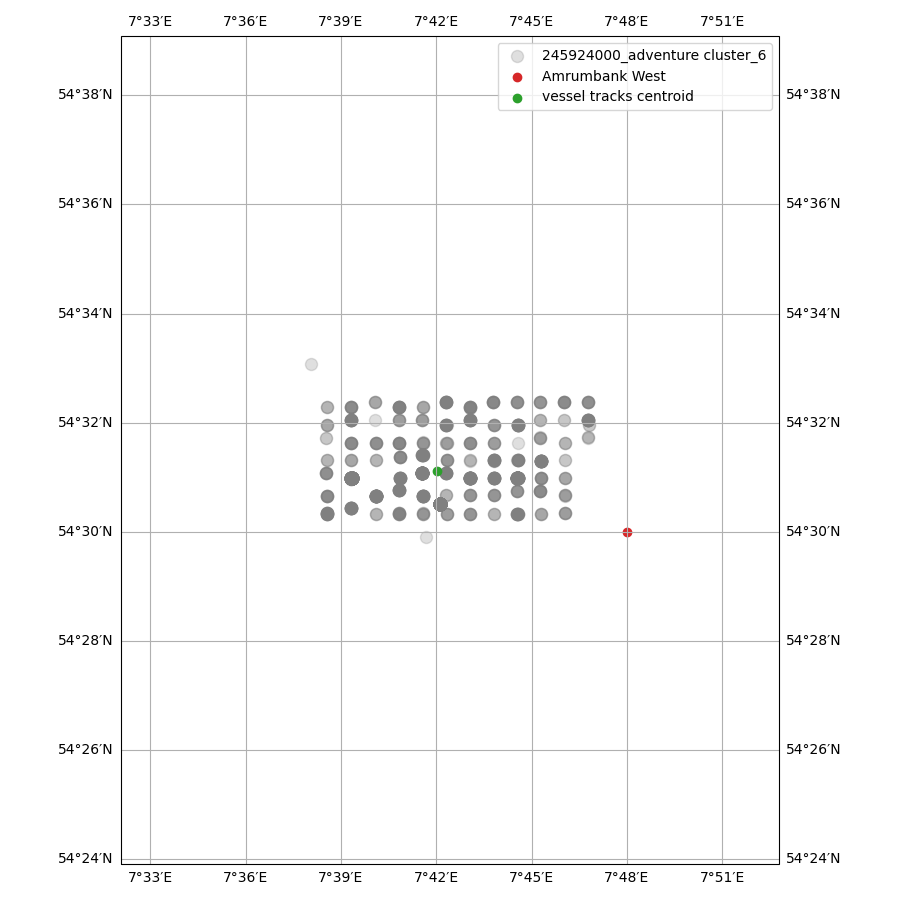

<IPython.core.display.Javascript object>


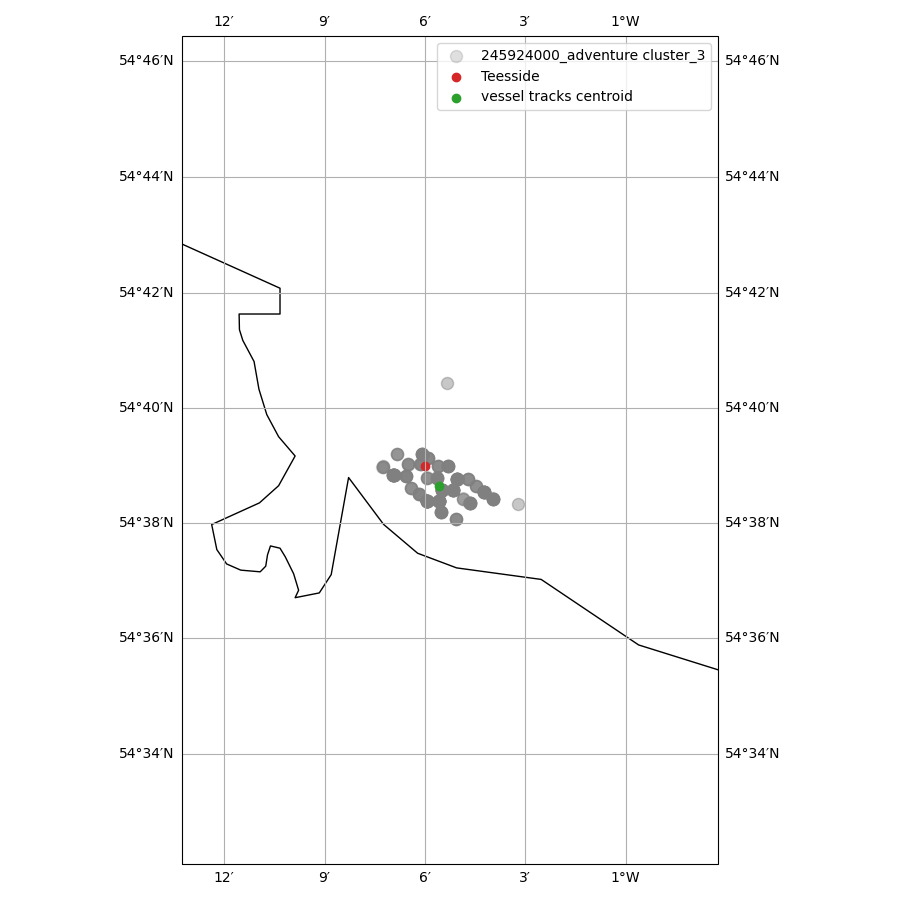

<IPython.core.display.Javascript object>


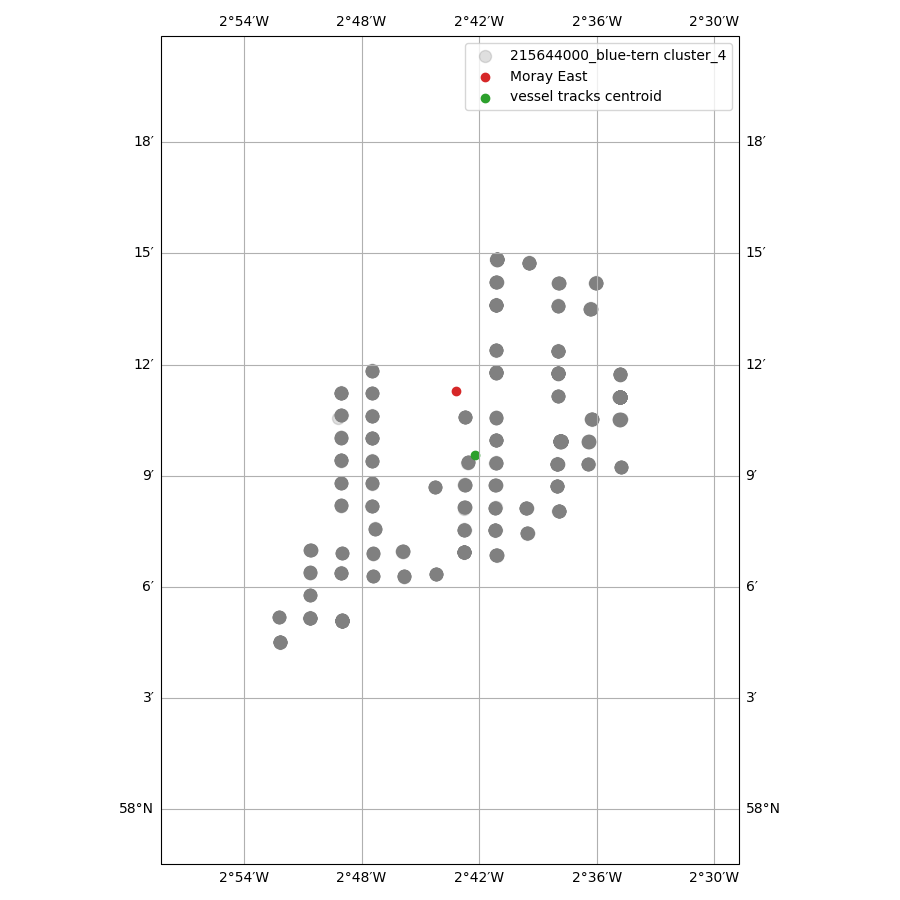

<IPython.core.display.Javascript object>


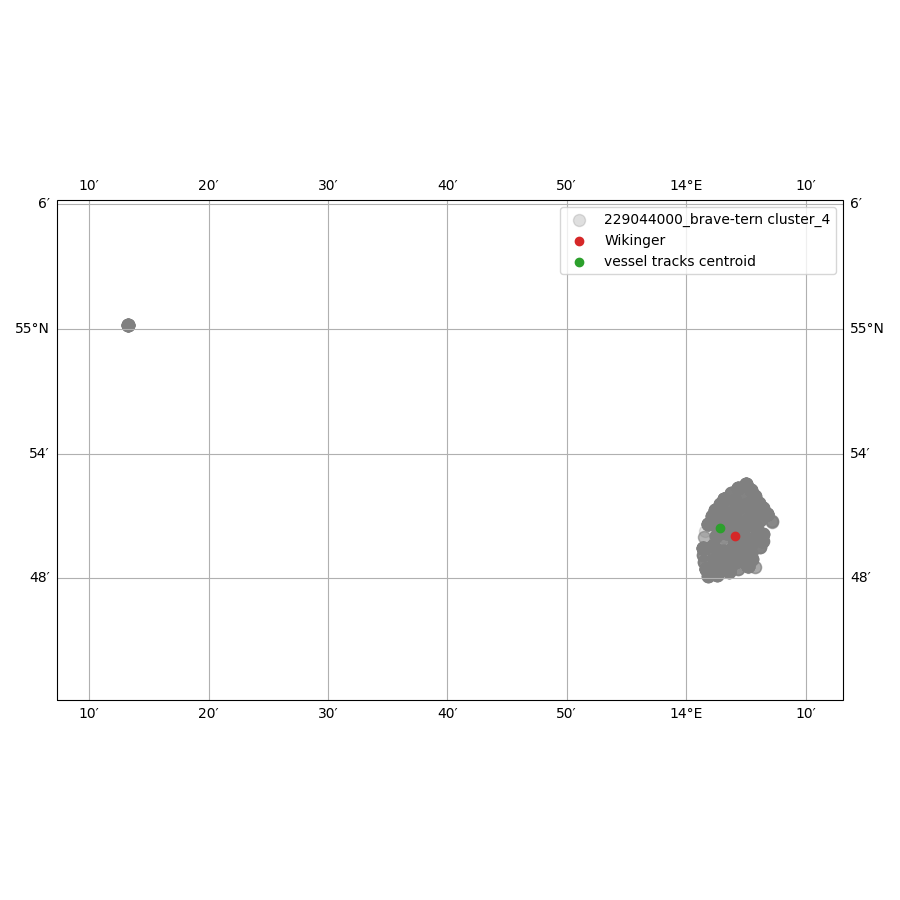

<IPython.core.display.Javascript object>


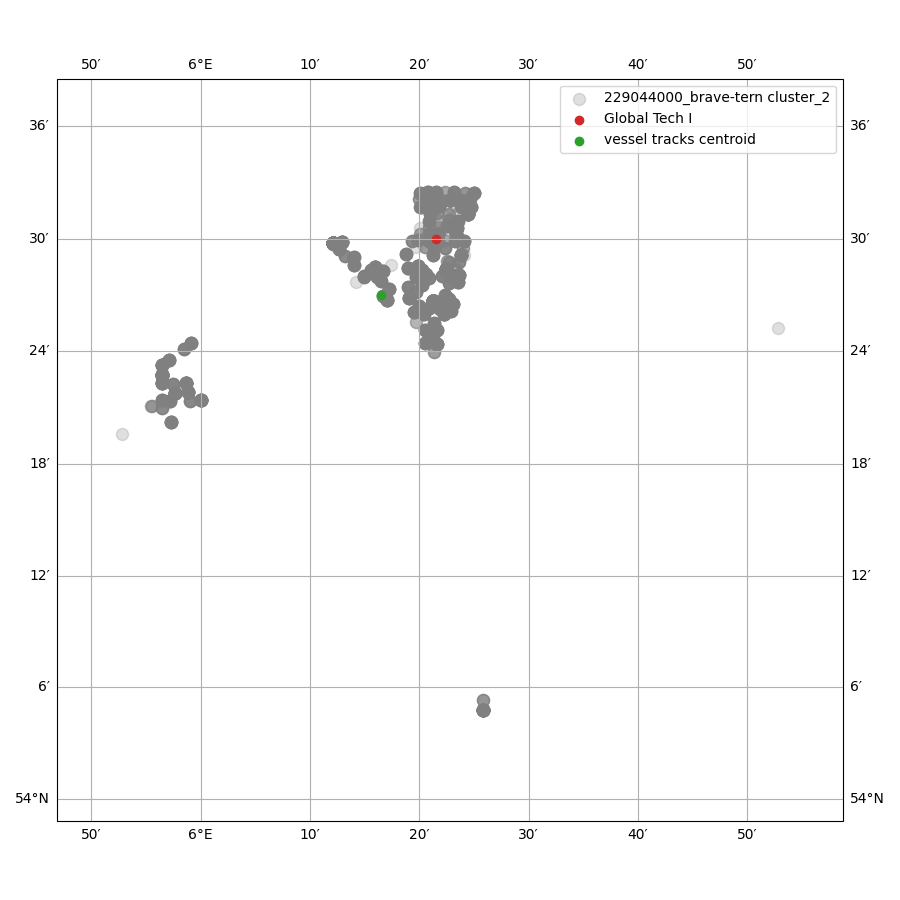

<IPython.core.display.Javascript object>


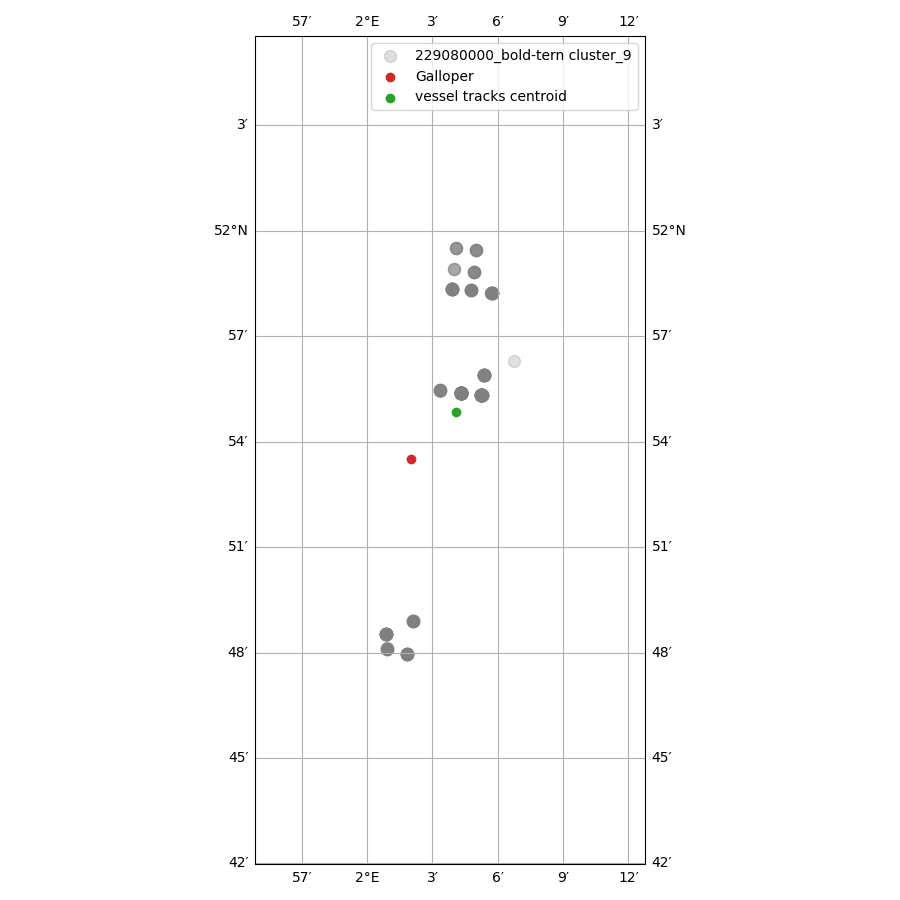

<IPython.core.display.Javascript object>


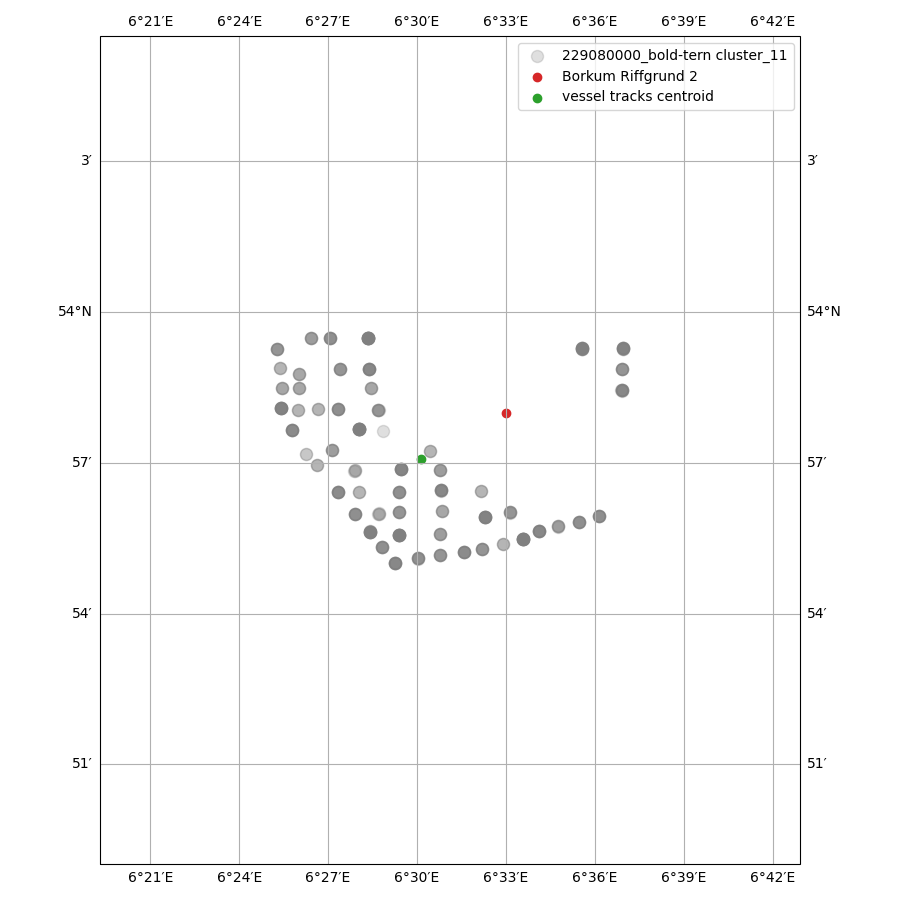

<IPython.core.display.Javascript object>


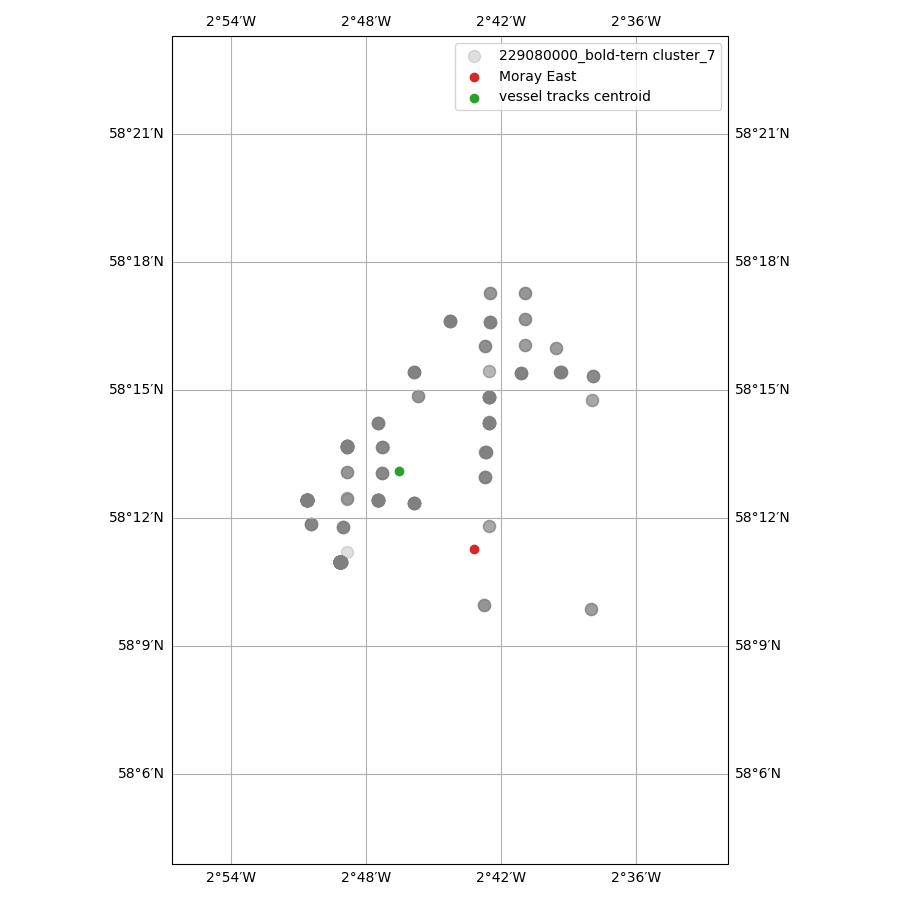

<IPython.core.display.Javascript object>


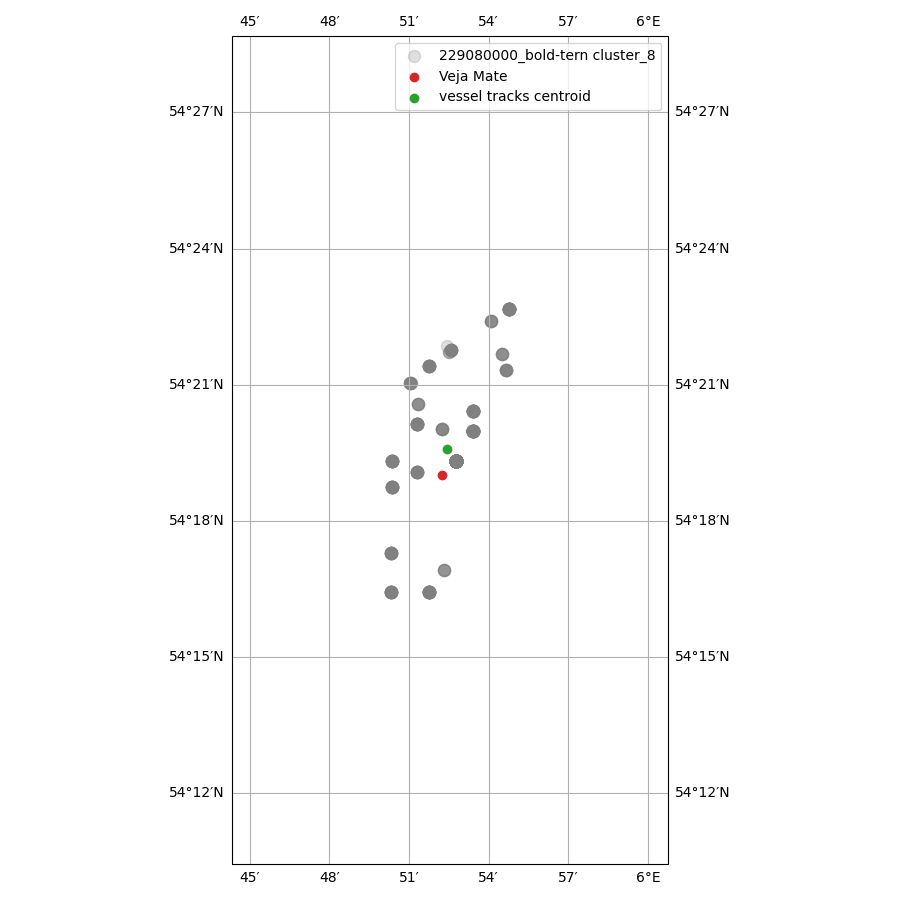

<IPython.core.display.Javascript object>


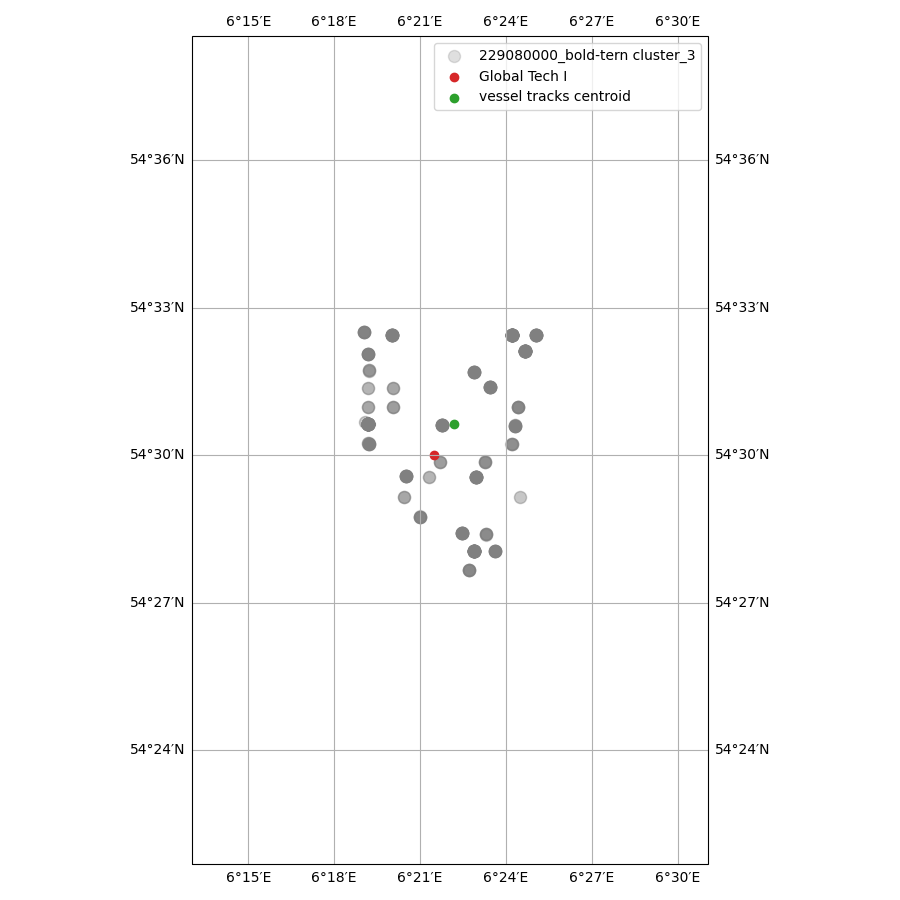

<IPython.core.display.Javascript object>


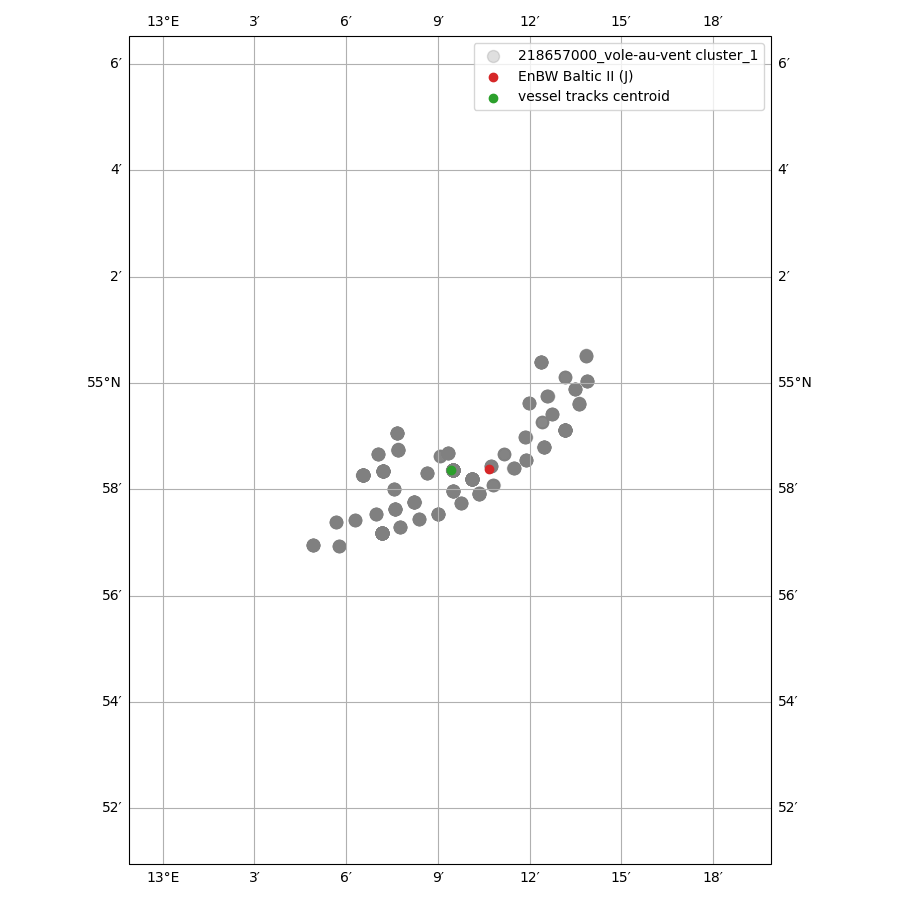

<IPython.core.display.Javascript object>


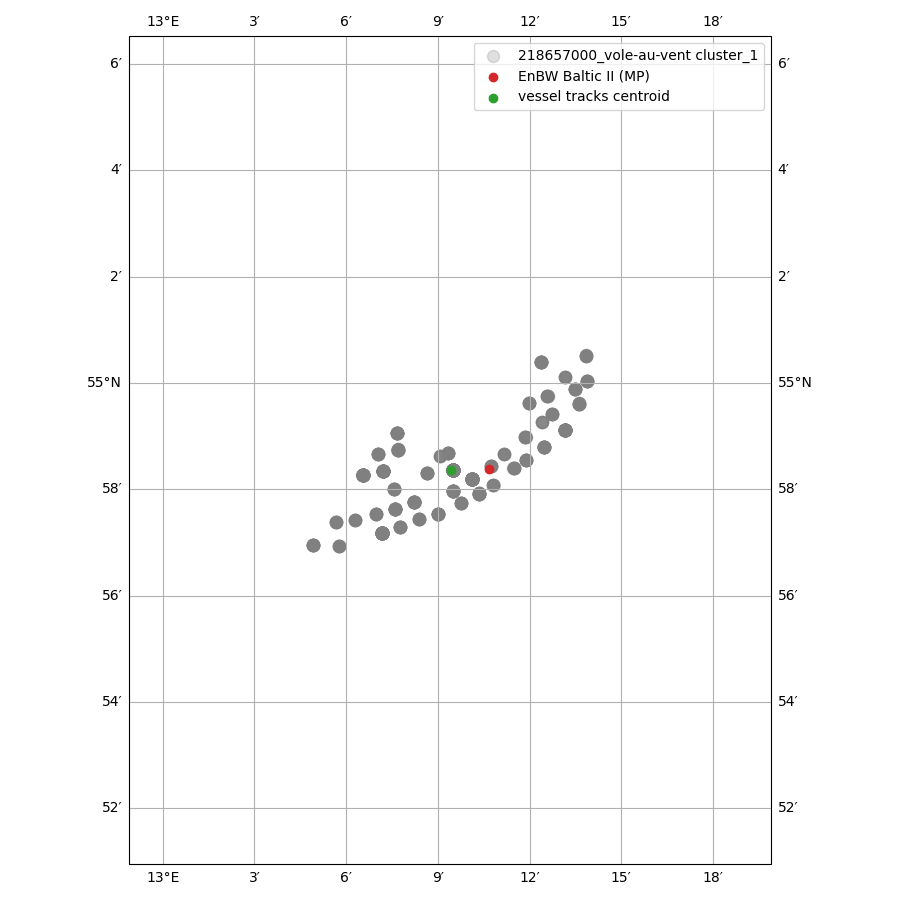

<IPython.core.display.Javascript object>


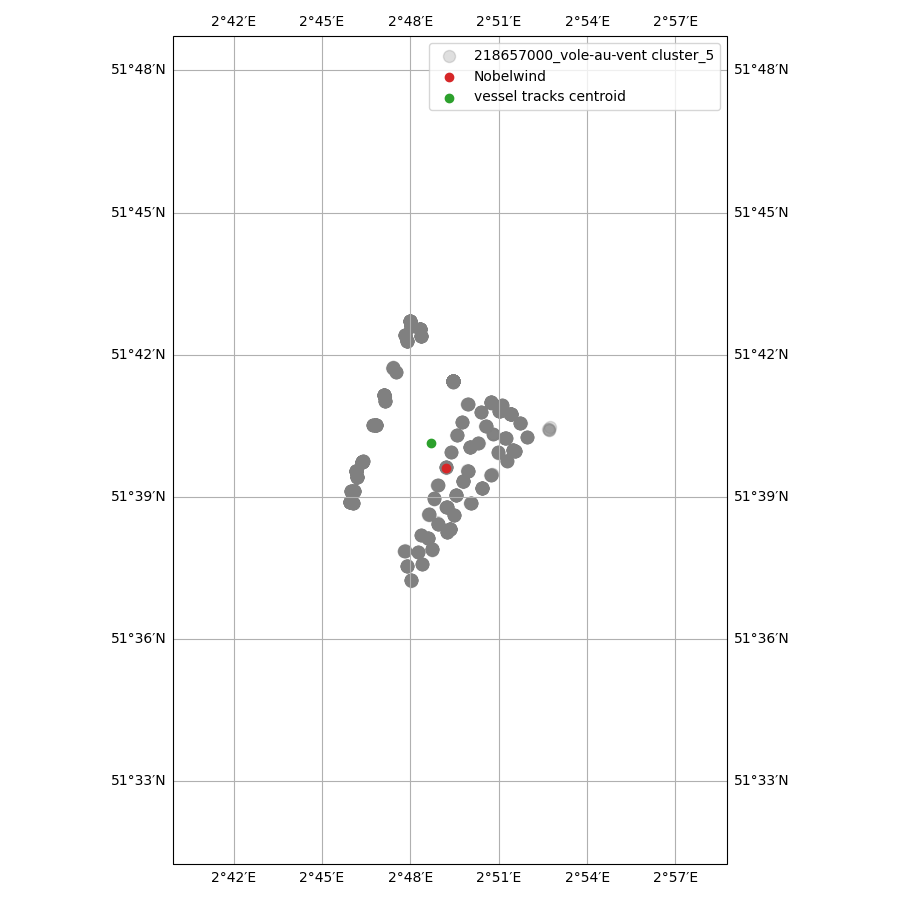

<IPython.core.display.Javascript object>


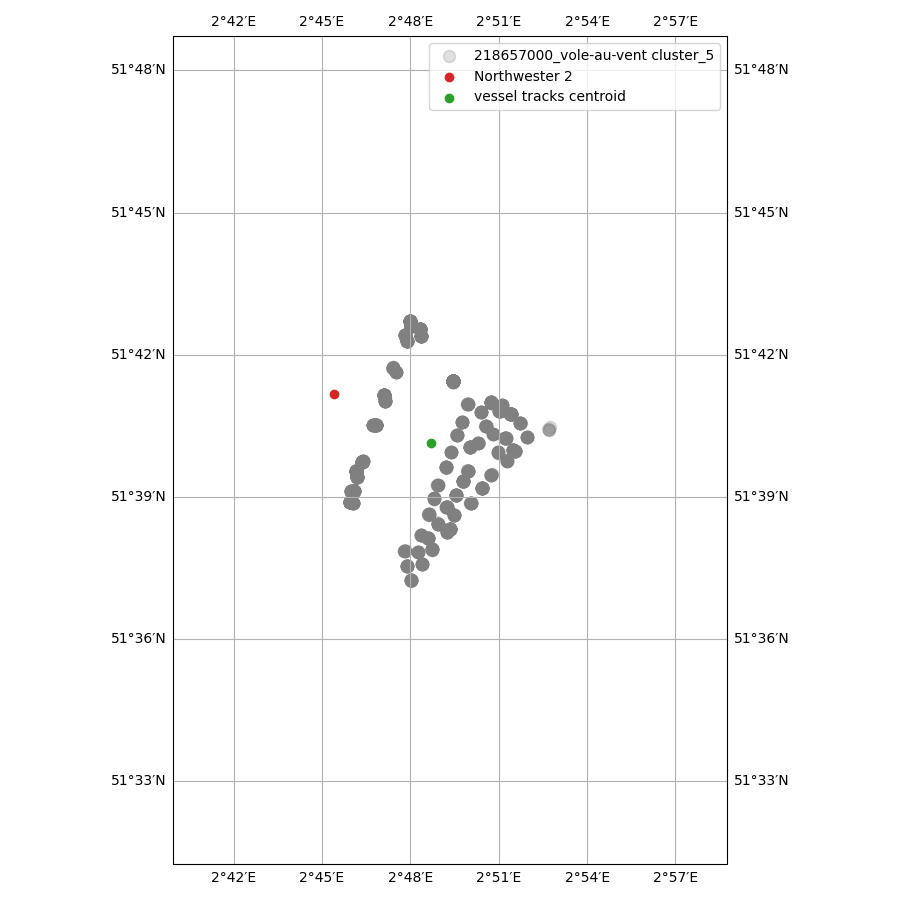

<IPython.core.display.Javascript object>


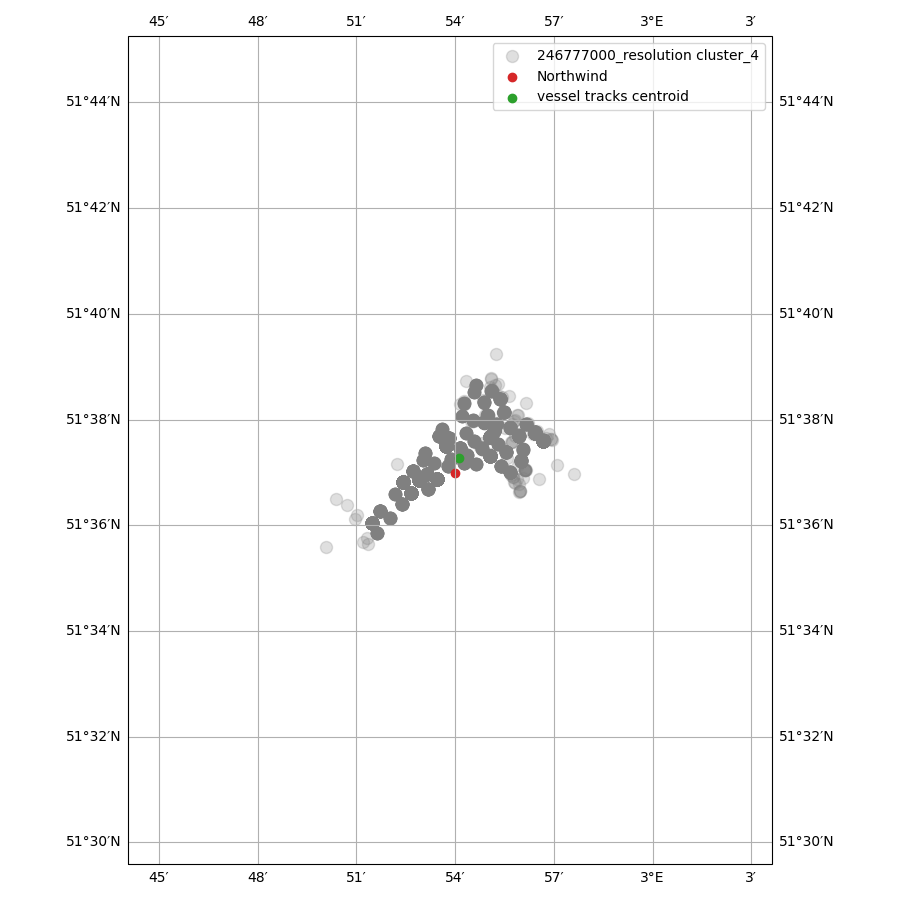

<IPython.core.display.Javascript object>


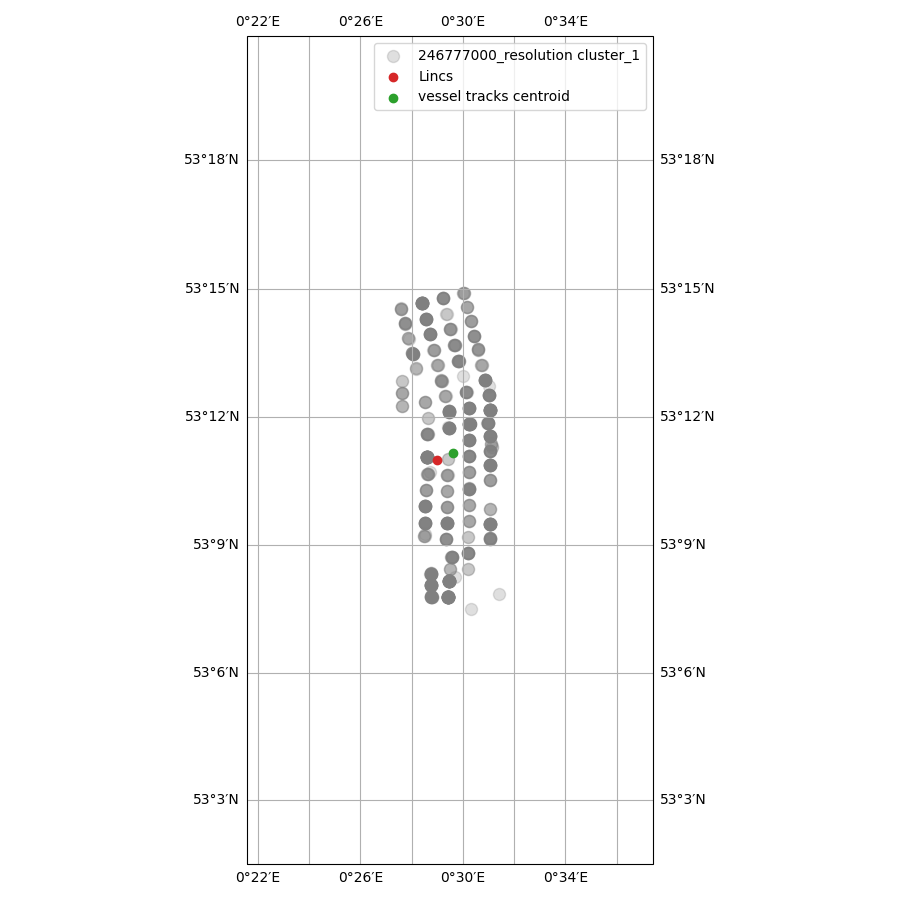

<IPython.core.display.Javascript object>


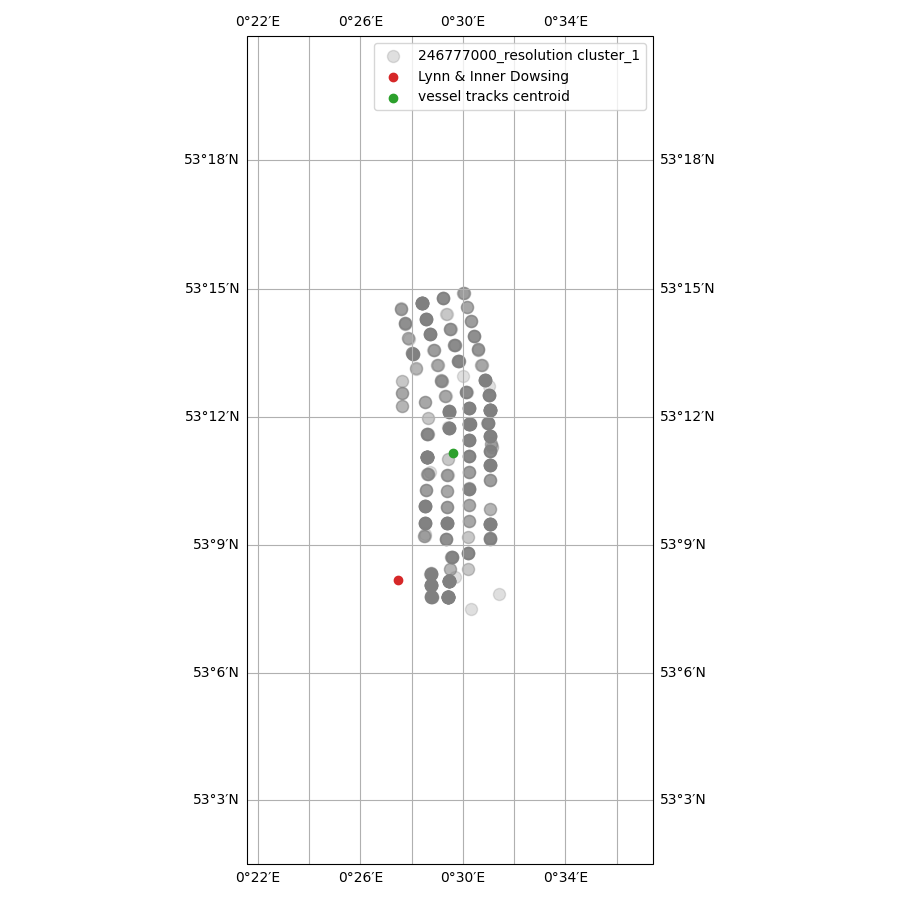

/tmp/ipykernel_541783/3568849045.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


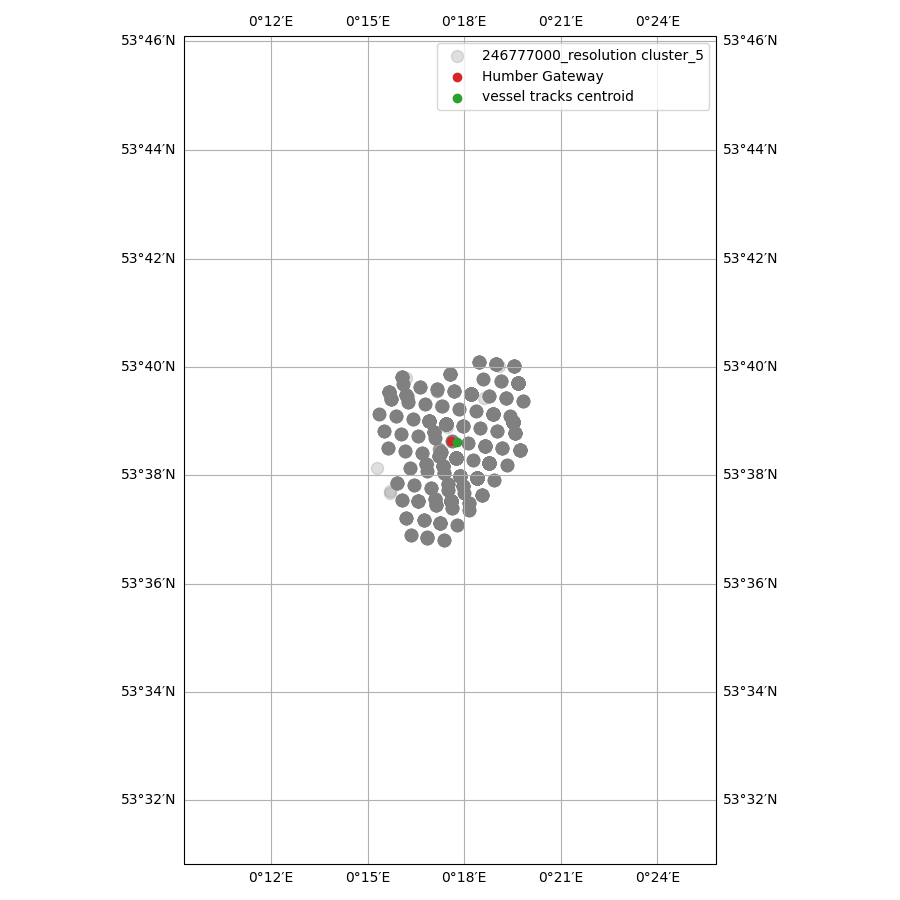

<IPython.core.display.Javascript object>


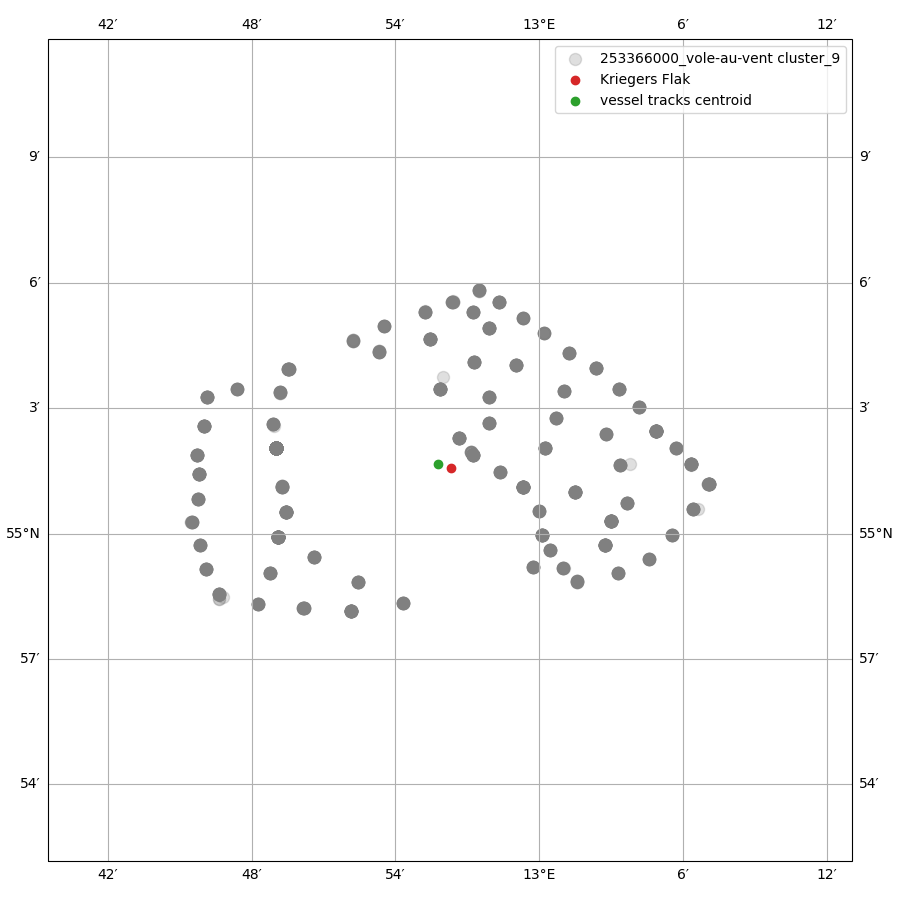

<IPython.core.display.Javascript object>


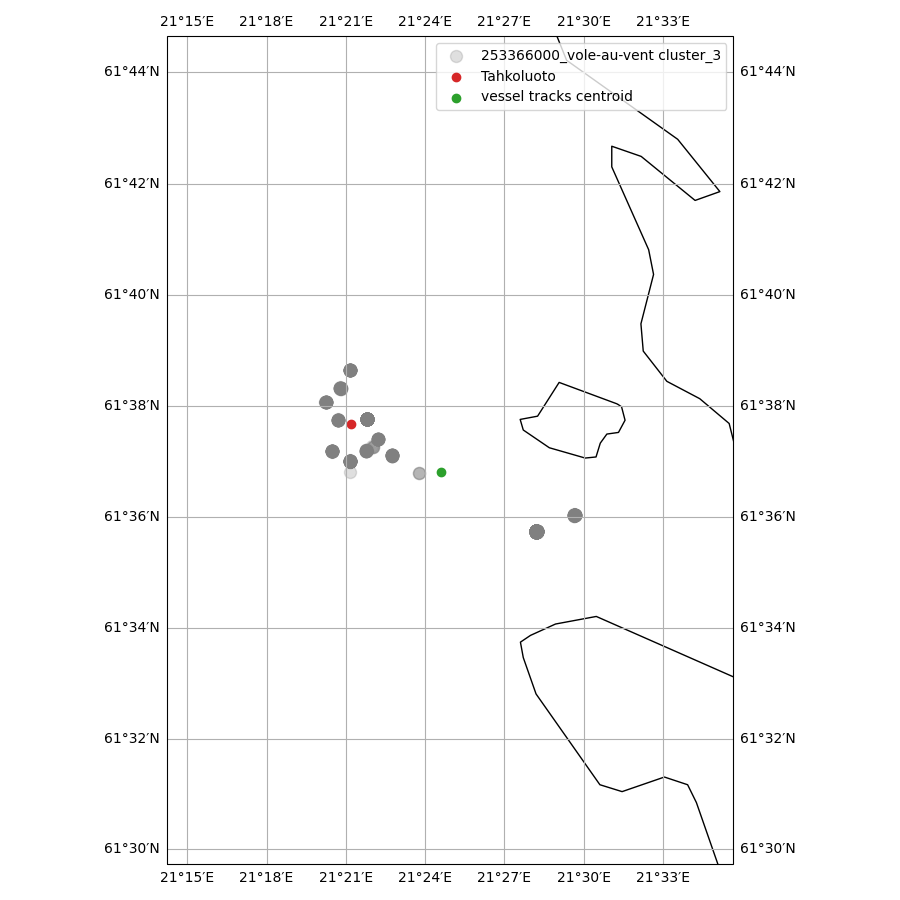

<IPython.core.display.Javascript object>


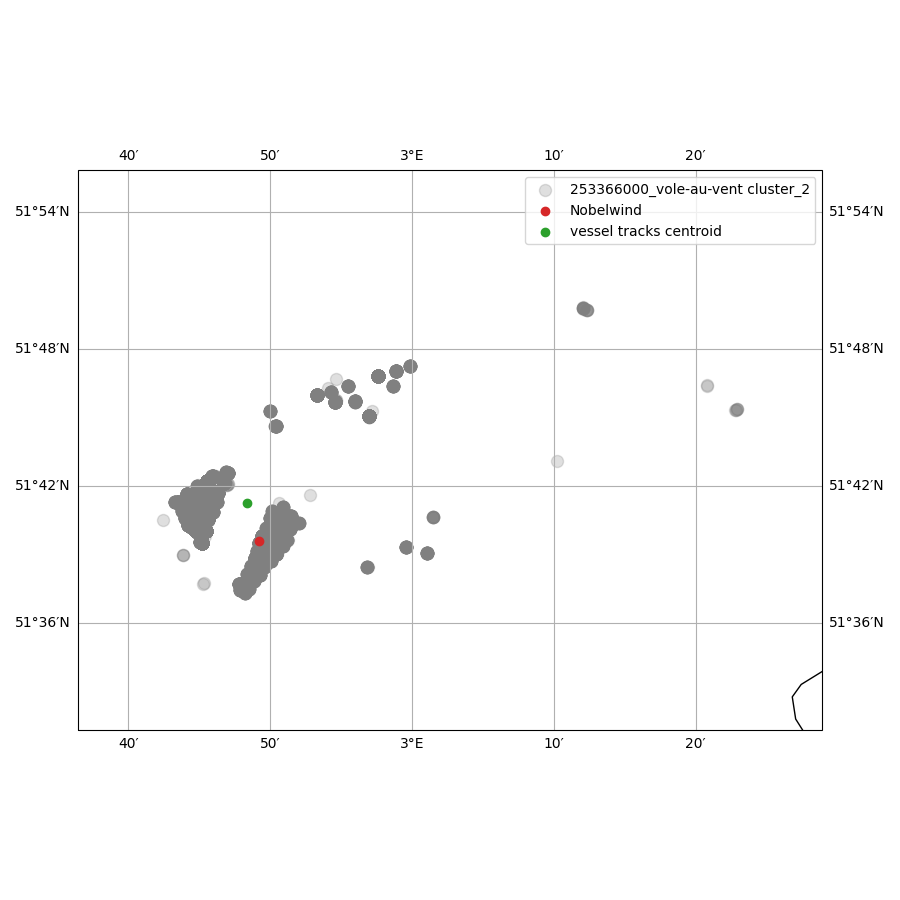

<IPython.core.display.Javascript object>


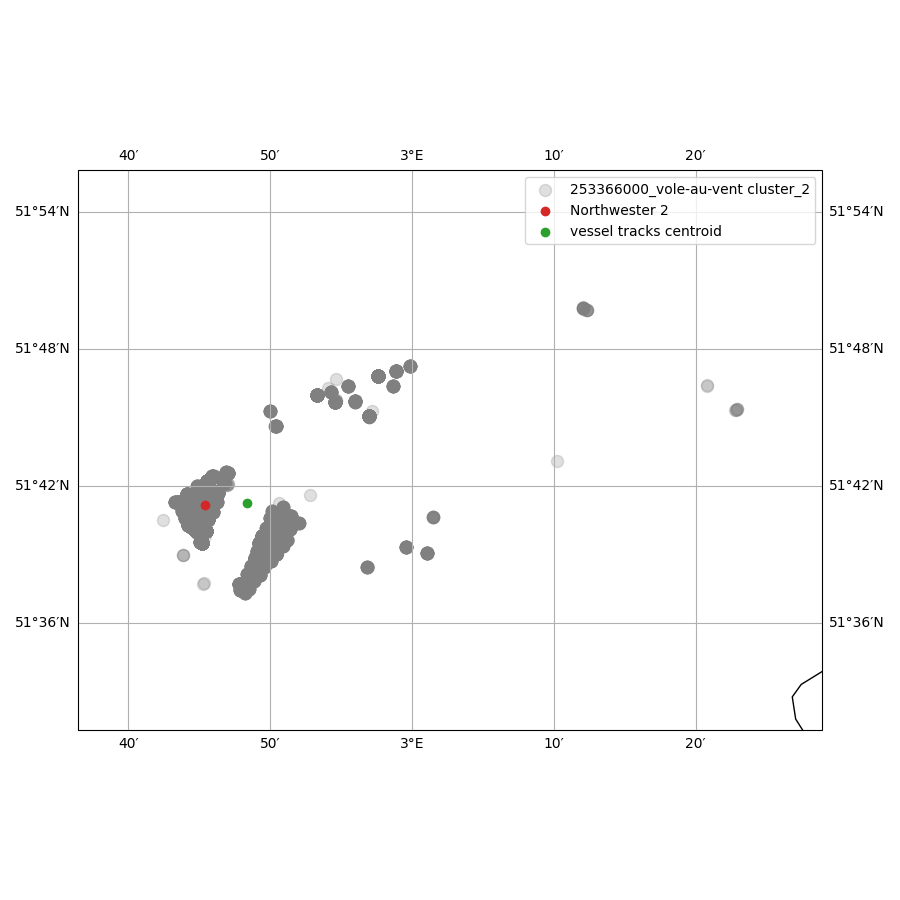

<IPython.core.display.Javascript object>


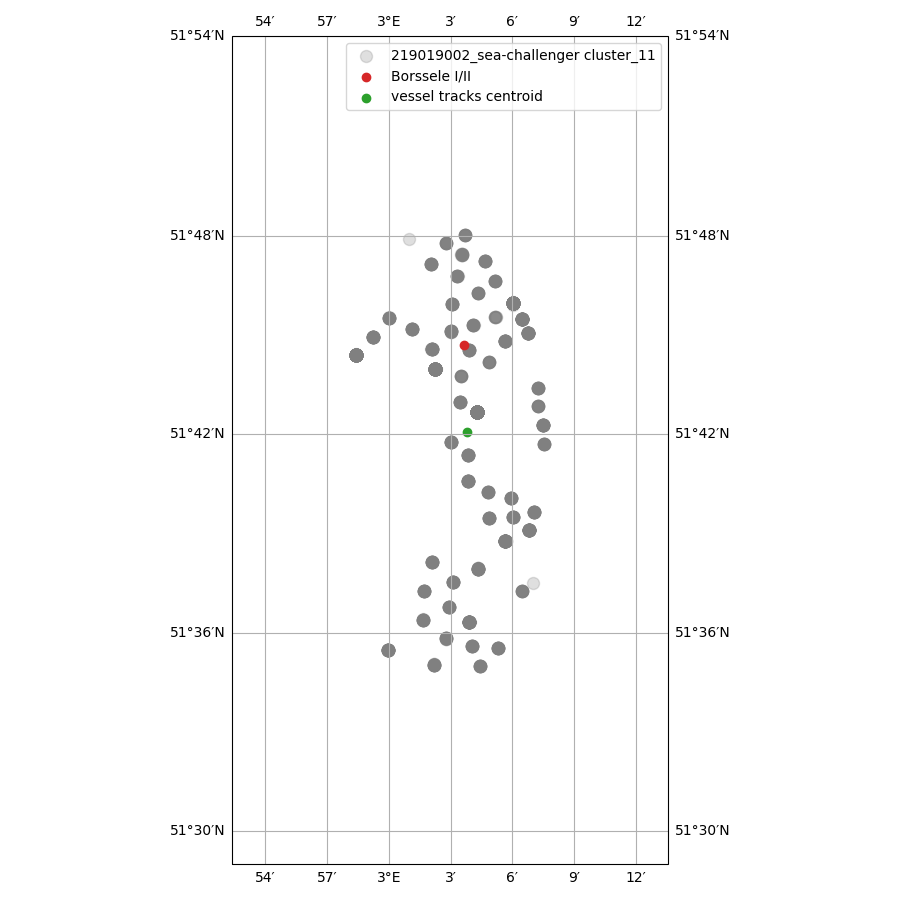

<IPython.core.display.Javascript object>


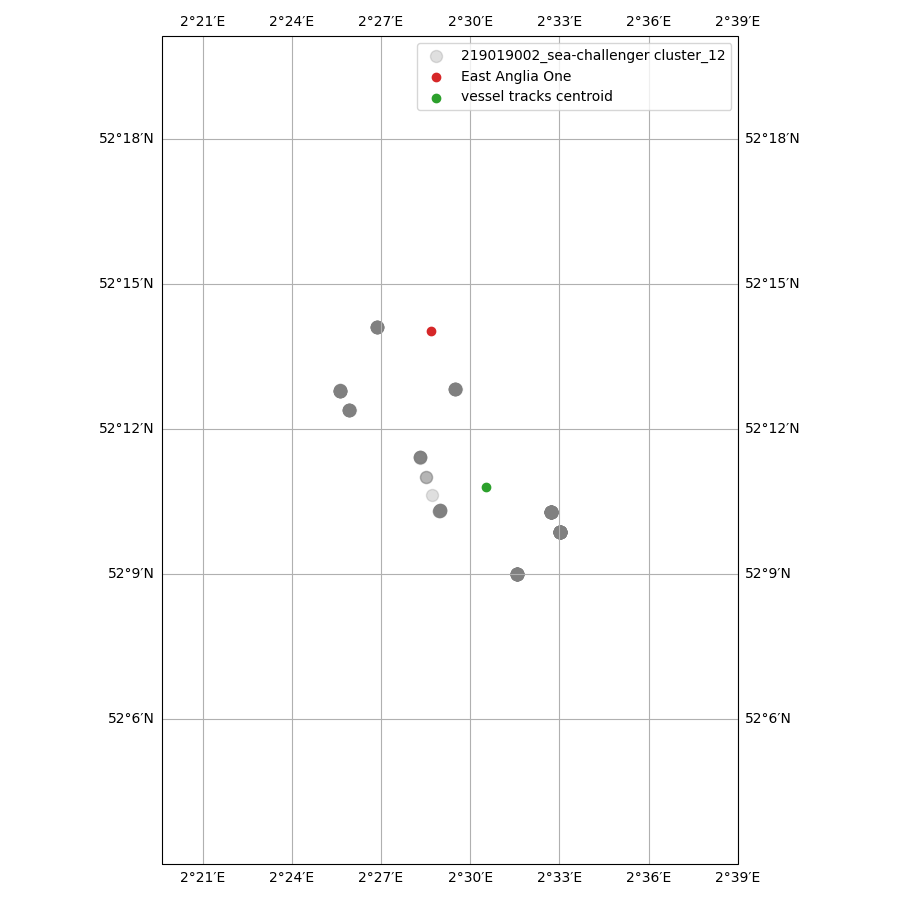

<IPython.core.display.Javascript object>


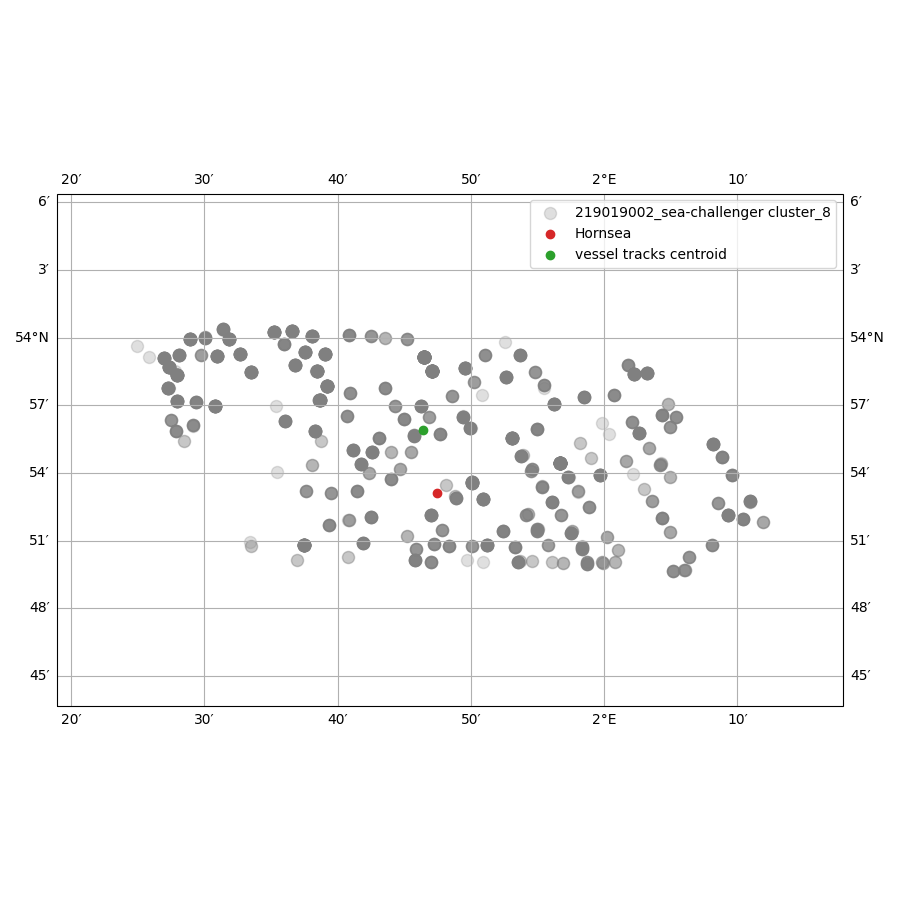

<IPython.core.display.Javascript object>


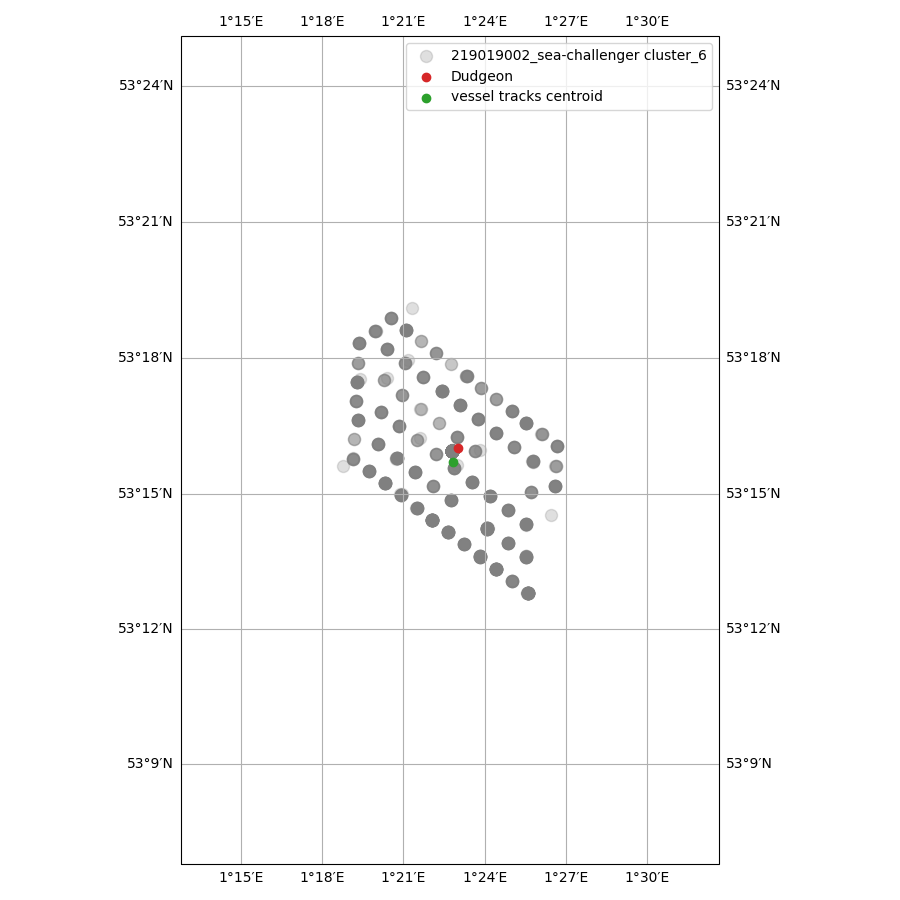

<IPython.core.display.Javascript object>


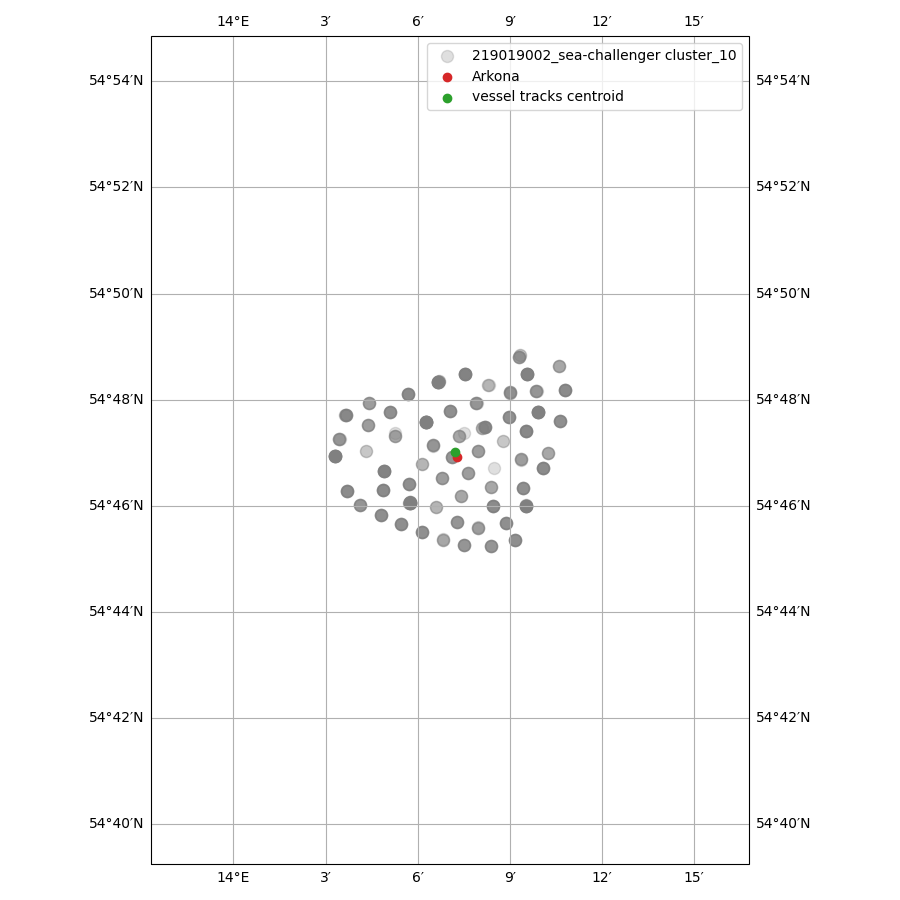

<IPython.core.display.Javascript object>


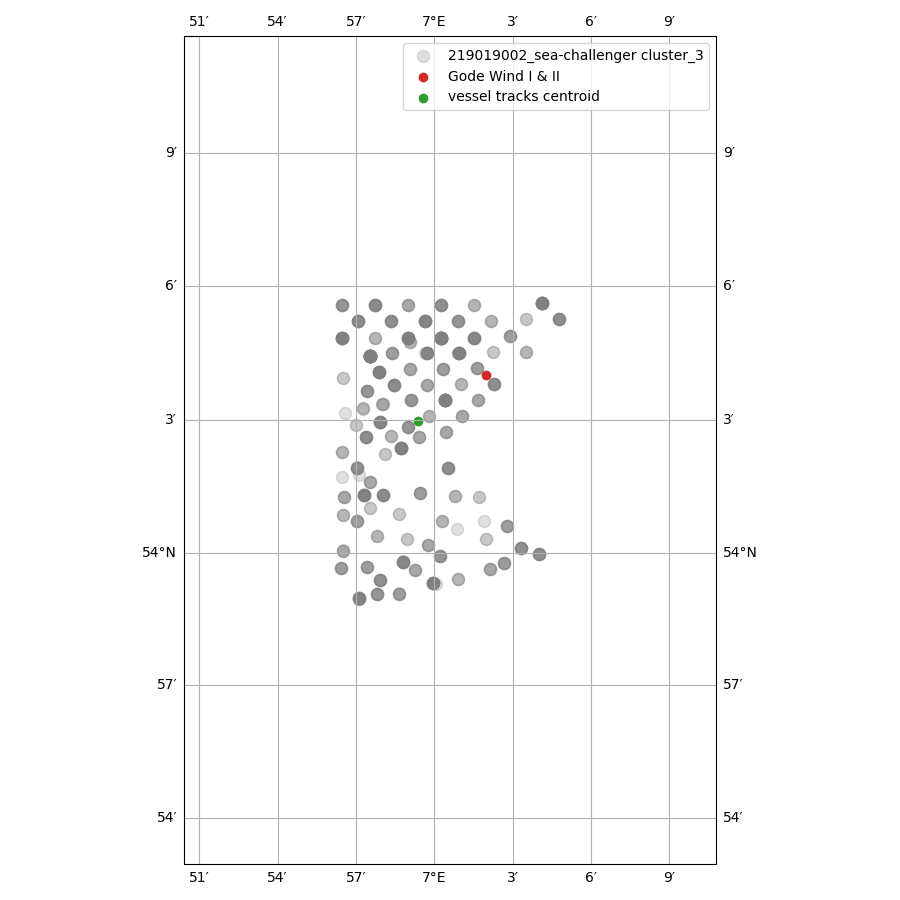

<IPython.core.display.Javascript object>


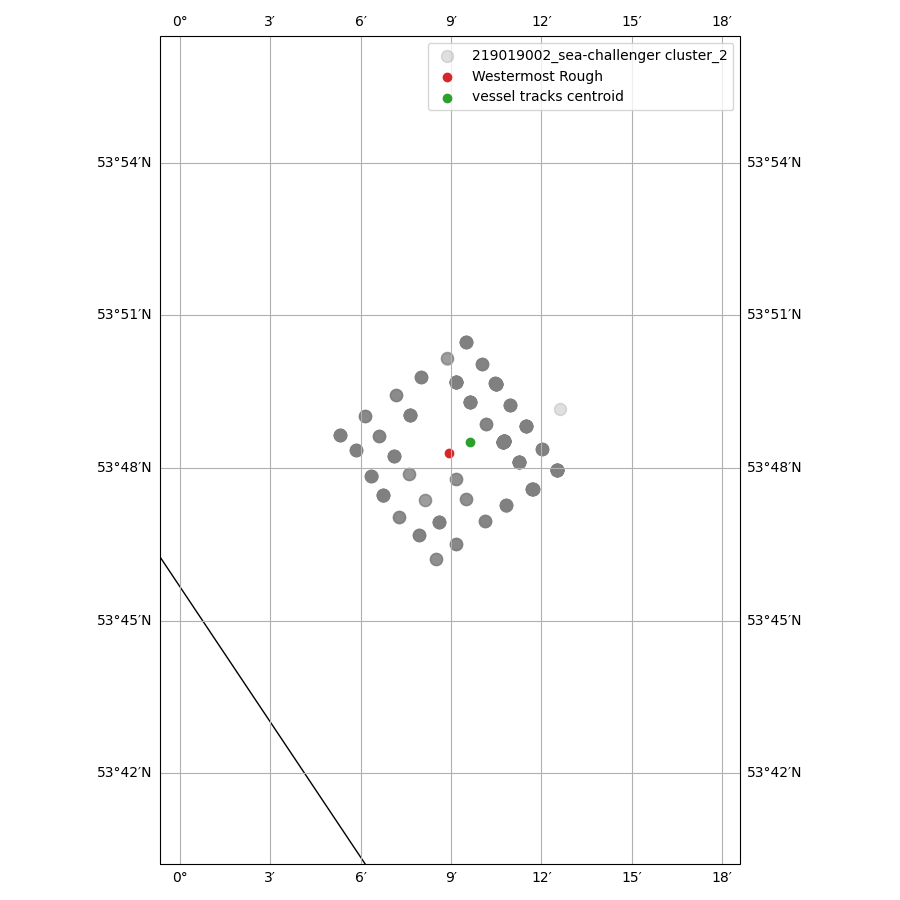

<IPython.core.display.Javascript object>


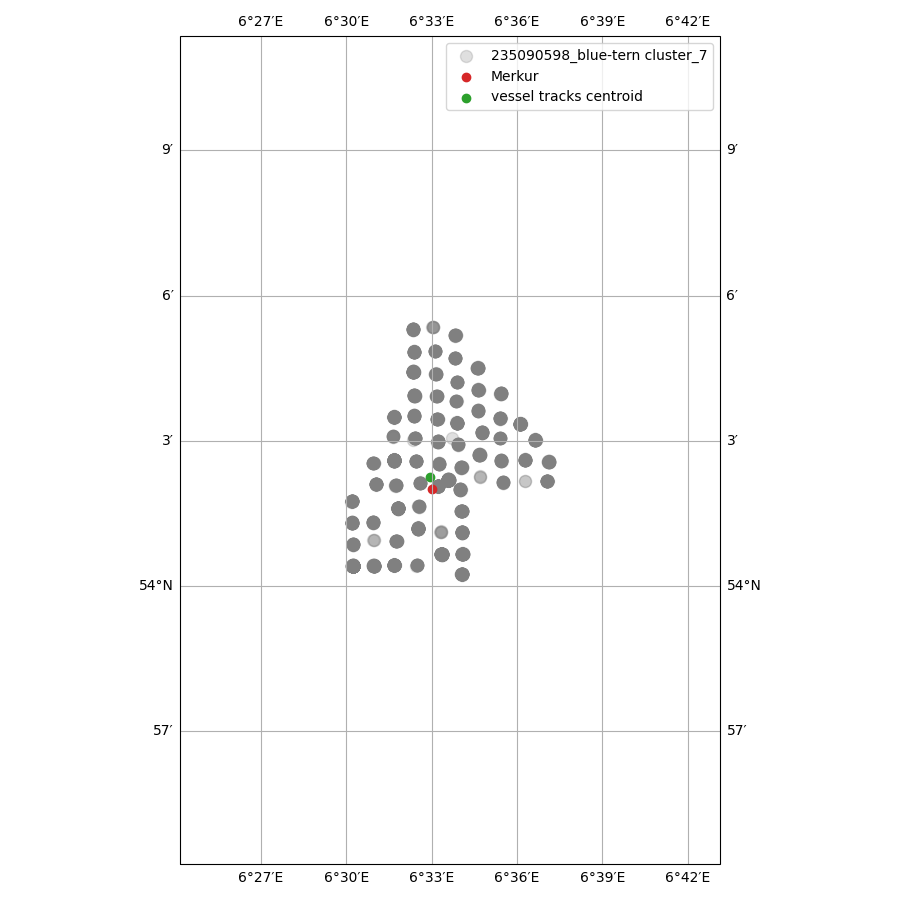

<IPython.core.display.Javascript object>


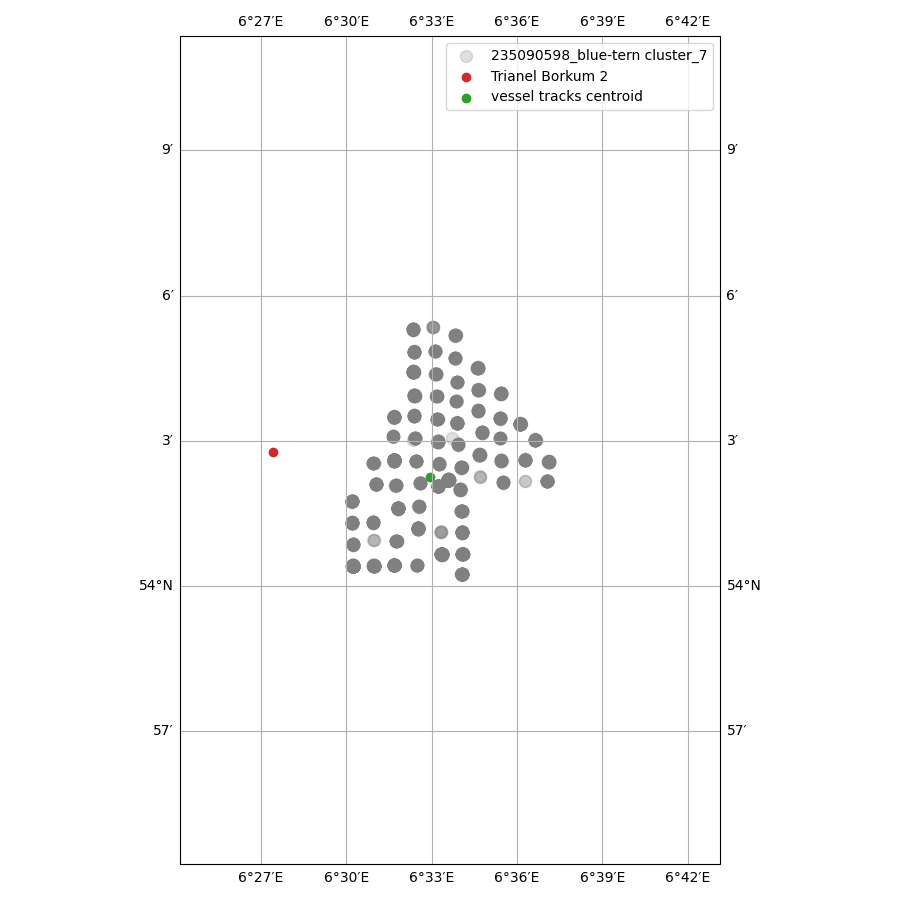

<IPython.core.display.Javascript object>


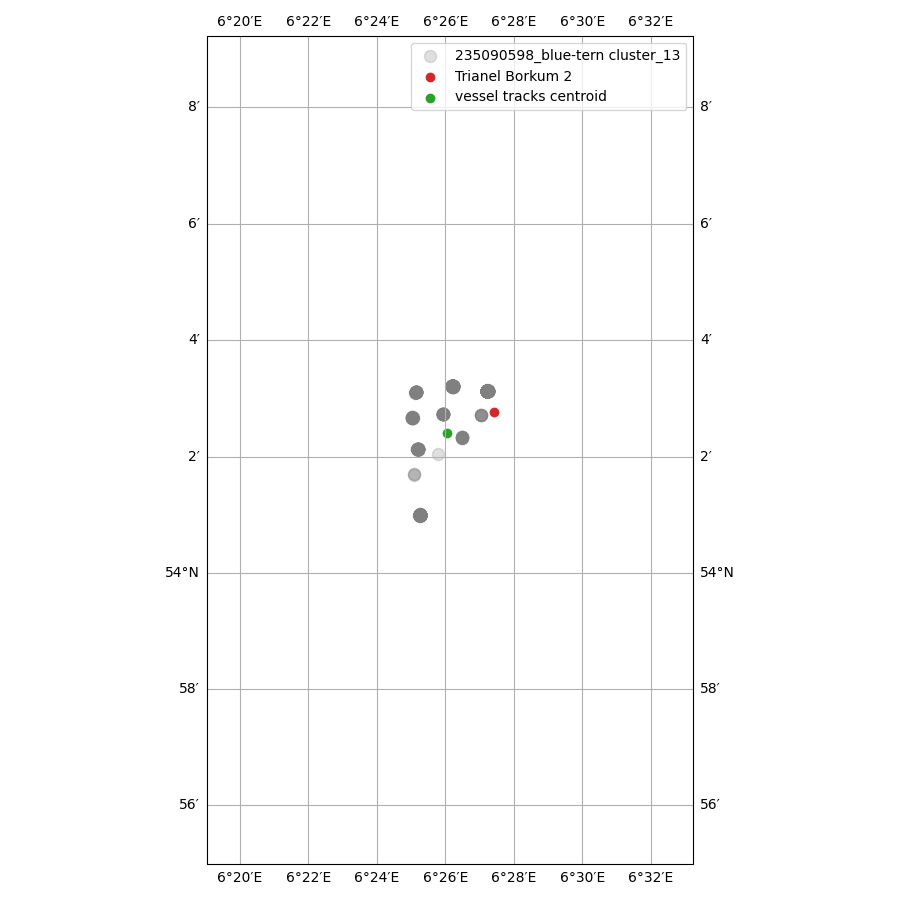

<IPython.core.display.Javascript object>


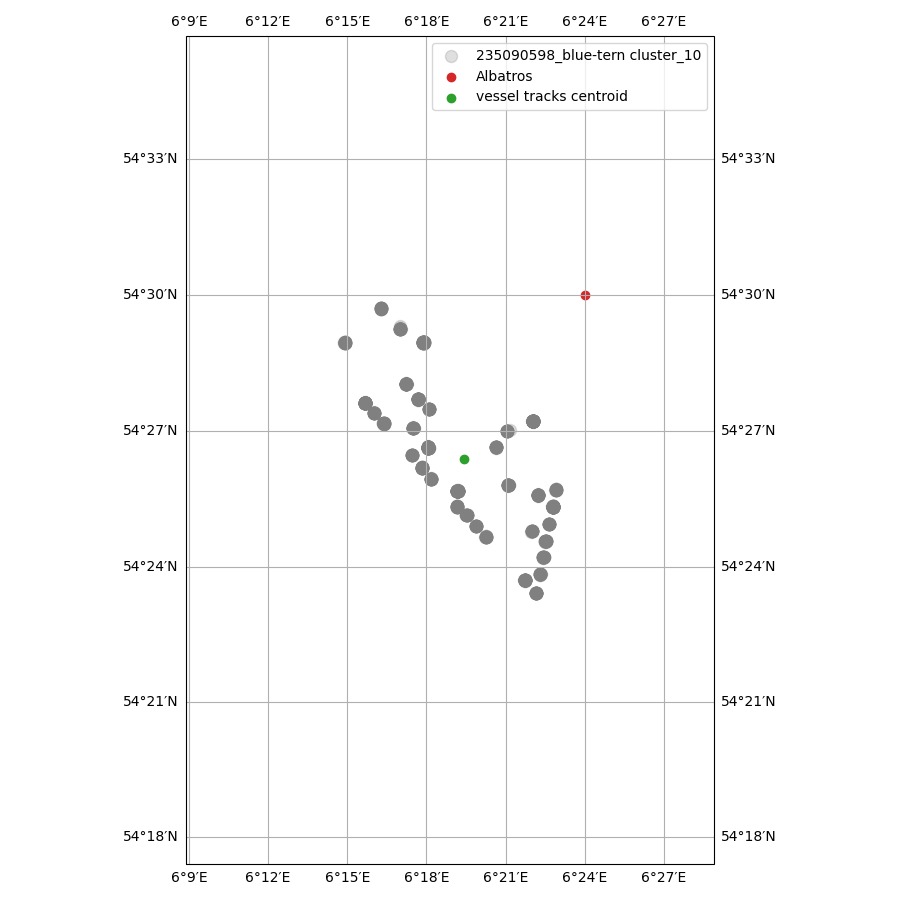

<IPython.core.display.Javascript object>


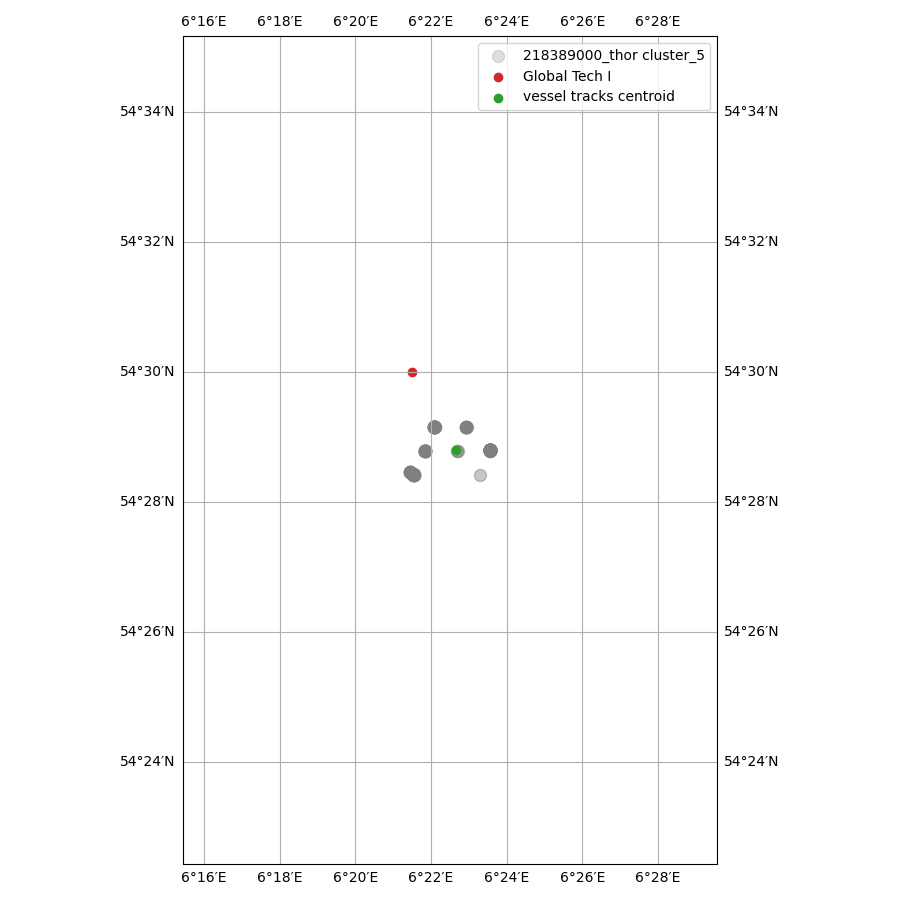

<IPython.core.display.Javascript object>


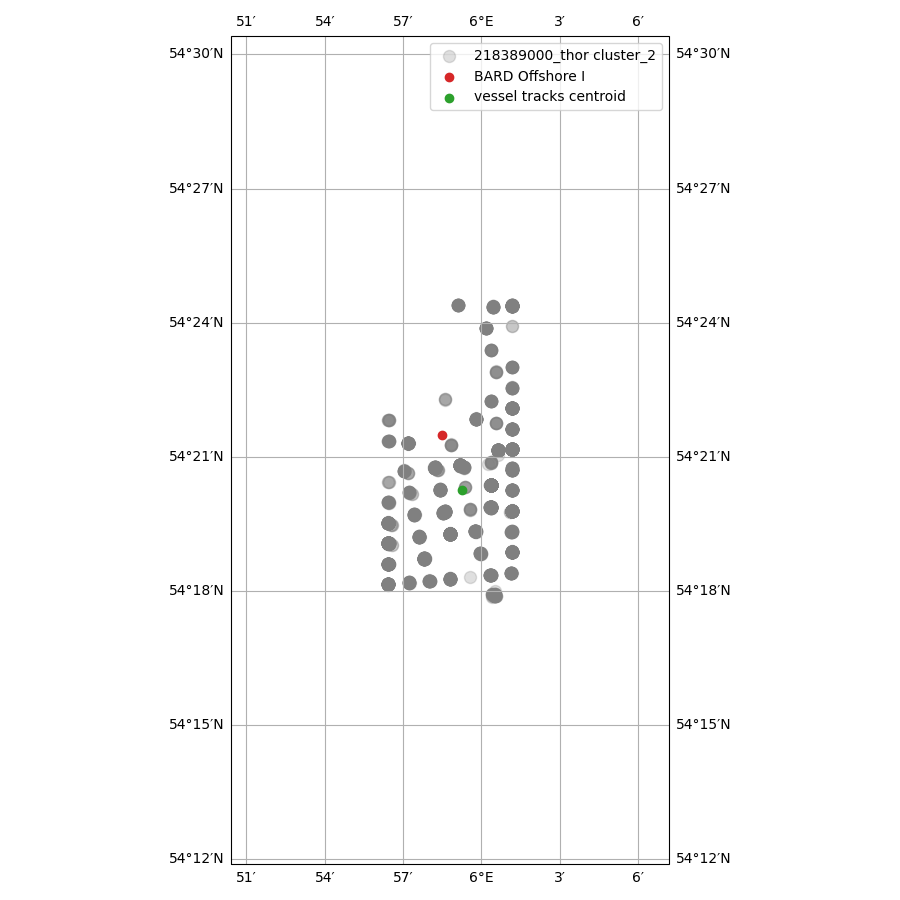

<IPython.core.display.Javascript object>


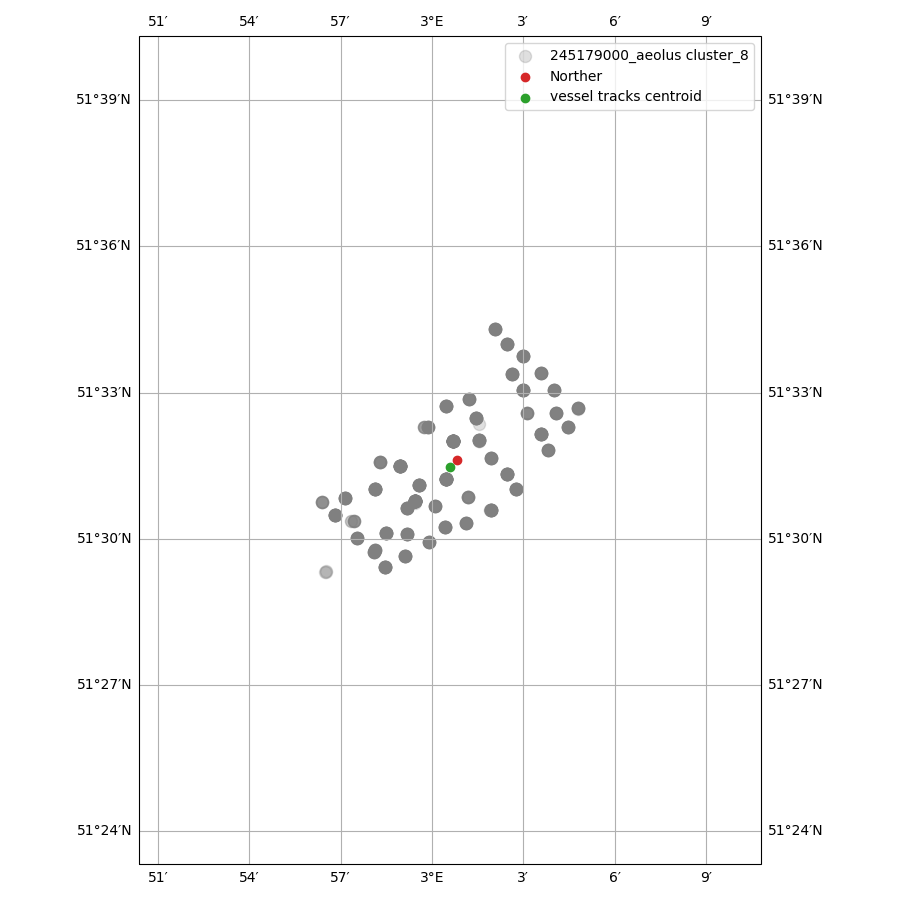

<IPython.core.display.Javascript object>


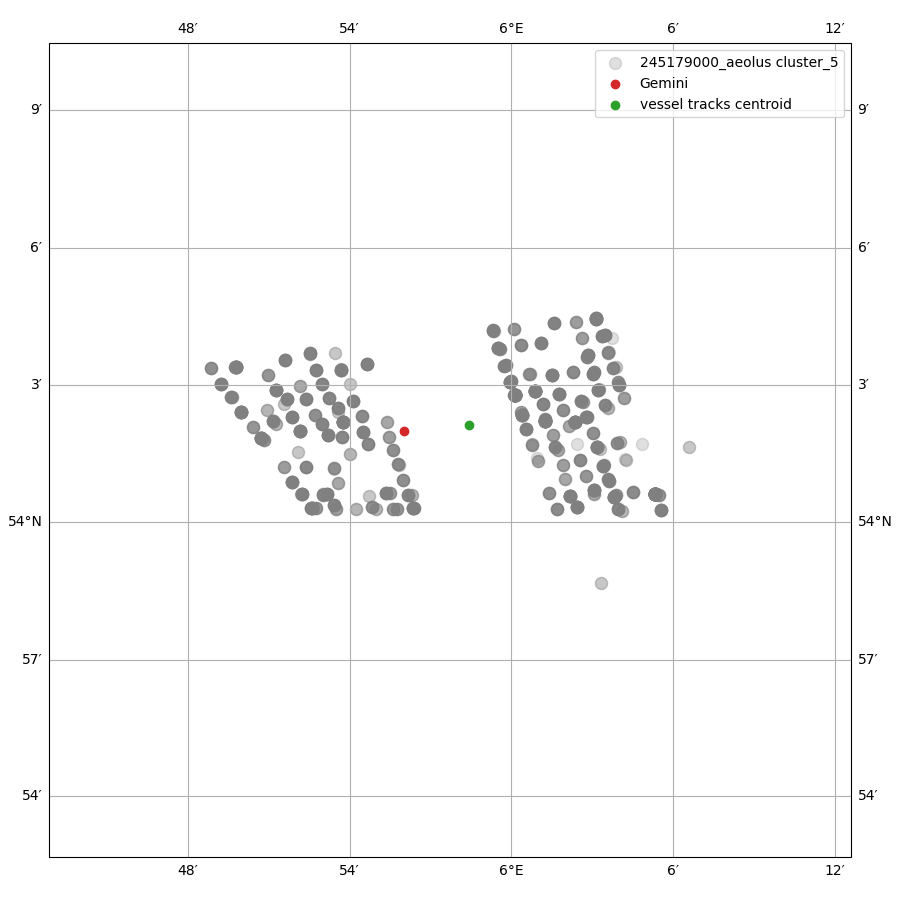

<IPython.core.display.Javascript object>


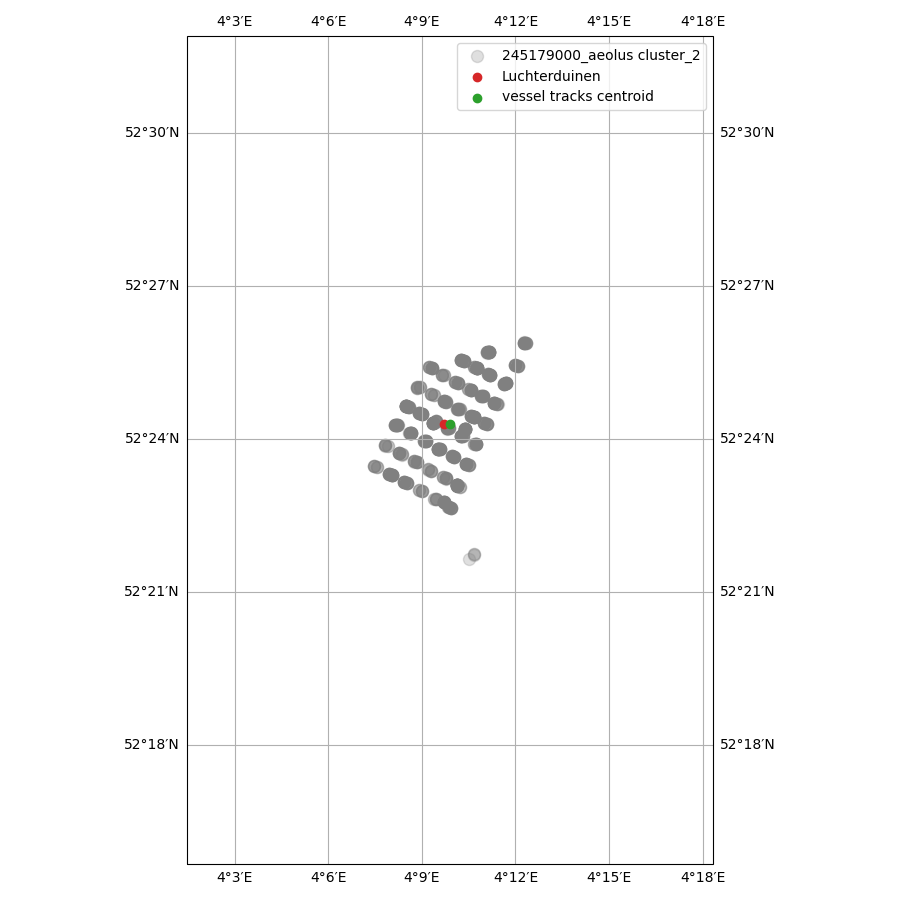

In [24]:
basedir = "../../data/marinetraffic/clustered/"
for _, matching_windfarm in matching_windfarms.iterrows():
    clusterpath = os.path.join(os.path.join(os.path.join(basedir, matching_windfarm.vesselname), matching_windfarm.clustername), f"{matching_windfarm.vesselname}_{matching_windfarm.clustername}.csv")
    if not os.path.isfile(clusterpath):
        print(f"no such file or directory: {clusterpath}")
    cluster = pd.read_csv(clusterpath)
    plot_cluster(cluster, windfarms.loc[matching_windfarm.windfarm_index], label=f'{matching_windfarm.vesselname} {matching_windfarm.clustername}', show_fig=True)